In [103]:
import pandas as pd
import numpy as np
from pathlib import Path

import opinionated
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("opinionated_fsc")
import colormaps as cmaps 

import module
import importlib
import warnings

try:
    importlib.reload(module)  # reload module
except NameError:
    pass

In [104]:
path = Path.cwd().parents[0] / "output/vote_result.xlsx"
df = pd.read_excel(path)

# Analisis Pemilu DPRP DKI 2019

*Updated 17 September 2023*

Berikut adalah laporan hasil analisis Pemilu DPRP DKI 2019. Analisis ini bertujuan untuk menggali insight dari hasil Pemilu DPRP DKI 2019 untuk menjawab pertanyaan: <p><strong><span style="color: purple;">Bagaimana skenario terbaik untuk terpilih di Pemilu DPRP DKI?</span></strong></p>


Laporan ini akan disajikan dalam bentuk pertanyaan.

---

## 1. Apakah Bergabung ke Partai Besar Lebih Baik dari Bergabung ke Partai Kecil?

Dalam kasus ini, **partai besar** akan kita artikan sebagai partai yang total suara partainya di atas median total suara dari seluruh partai. 
Sebaliknya, **partai kecil** akan kita artikan sebagai partai yang total suara partainya nya di bawah median total suara dari seluruh partai. 

Kenapa kita memakai median, bukan mean/rata-rata? Karena distribusi suara terhadap partai sangat tidak seimbang. Partai-partai yang paling besar mendapat jauh lebih suara sibanding partai lain. Karena itu, kita memilih median.

Berikut adalah tabel partai, total vote beserta ukurannya.

In [105]:
data_partai = (df
    .loc[:, ["dapil_no", "partai", "partai_vote"]]
    .drop_duplicates()
    .groupby("partai")
    .agg(total_suara_partai=("partai_vote", "sum"))
    .sort_values("total_suara_partai", ascending=False)
    .reset_index()
    .assign(
        ukuran_partai=lambda df_: np.where(
            (df_["total_suara_partai"] < df_["total_suara_partai"].median()),
            "Partai Kecil",
            "Partai Besar",
        )
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
)
data_partai

,Partai,Total Suara Partai,Ukuran Partai
0,PDIP,568094,Partai Besar
1,Gerindra,283887,Partai Besar
2,PKS,273862,Partai Besar
3,PSI,185166,Partai Besar
4,Demokrat,108641,Partai Besar
5,PKB,92451,Partai Besar
6,PAN,88689,Partai Besar
7,Nasdem,82202,Partai Besar
8,Golkar,76441,Partai Kecil
9,Perindo,72813,Partai Kecil


Selain itu, kita perlu mencari jumlah calon per partai dan jumlah calon terpilih per partai.

In [106]:
data_partai_full = (df
    .groupby("partai")
    .agg(
        jumlah_calon=("nama", "size"),
        jumlah_terpilih=("terpilih", "sum"),
        total_suara_calon=("vote", "sum"),
    )
    .reset_index()
    .assign(
        persentase_terpilih=lambda df_: df_["jumlah_terpilih"]
        .div(df_["jumlah_calon"])
        .mul(100)
        .round(1)
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .merge(right=data_partai, on="Partai")
    .sort_values("Total Suara Partai", ignore_index=True, ascending=False)
    .loc[
        :,
        [
            "Partai",
            "Jumlah Calon",
            "Jumlah Terpilih",
            "Persentase Terpilih",
            "Total Suara Calon",
            "Total Suara Partai",
            "Ukuran Partai",
        ],
    ]
)
data_partai_full

,Partai,Jumlah Calon,Jumlah Terpilih,Persentase Terpilih,Total Suara Calon,Total Suara Partai,Ukuran Partai
0,PDIP,106,25,23.6,768230,568094,Partai Besar
1,Gerindra,106,19,17.9,651906,283887,Partai Besar
2,PKS,106,16,15.1,643143,273862,Partai Besar
3,PSI,106,8,7.5,219342,185166,Partai Besar
4,Demokrat,106,10,9.4,277793,108641,Partai Besar
5,PKB,106,5,4.7,215761,92451,Partai Besar
6,PAN,106,9,8.5,287193,88689,Partai Besar
7,Nasdem,106,7,6.6,227588,82202,Partai Besar
8,Golkar,106,6,5.7,223805,76441,Partai Kecil
9,Perindo,106,0,0.0,95483,72813,Partai Kecil


Dari tabel ini, bisa kita lihat trend yang jelas: 
1. Suara terhadap partai berbanding lurus dengan suara terhadap calon.
2. Semakin besar partai, semakin besar pula persentase calon dari partai tersebut yang terpilih.
3. Partai kecil hanya menyumbang 7 calon terpilih dari total 106 calon terpilih. Jumlah yang sangat kecil.

Mari kita lihat lebih dekat trend trend diatas.

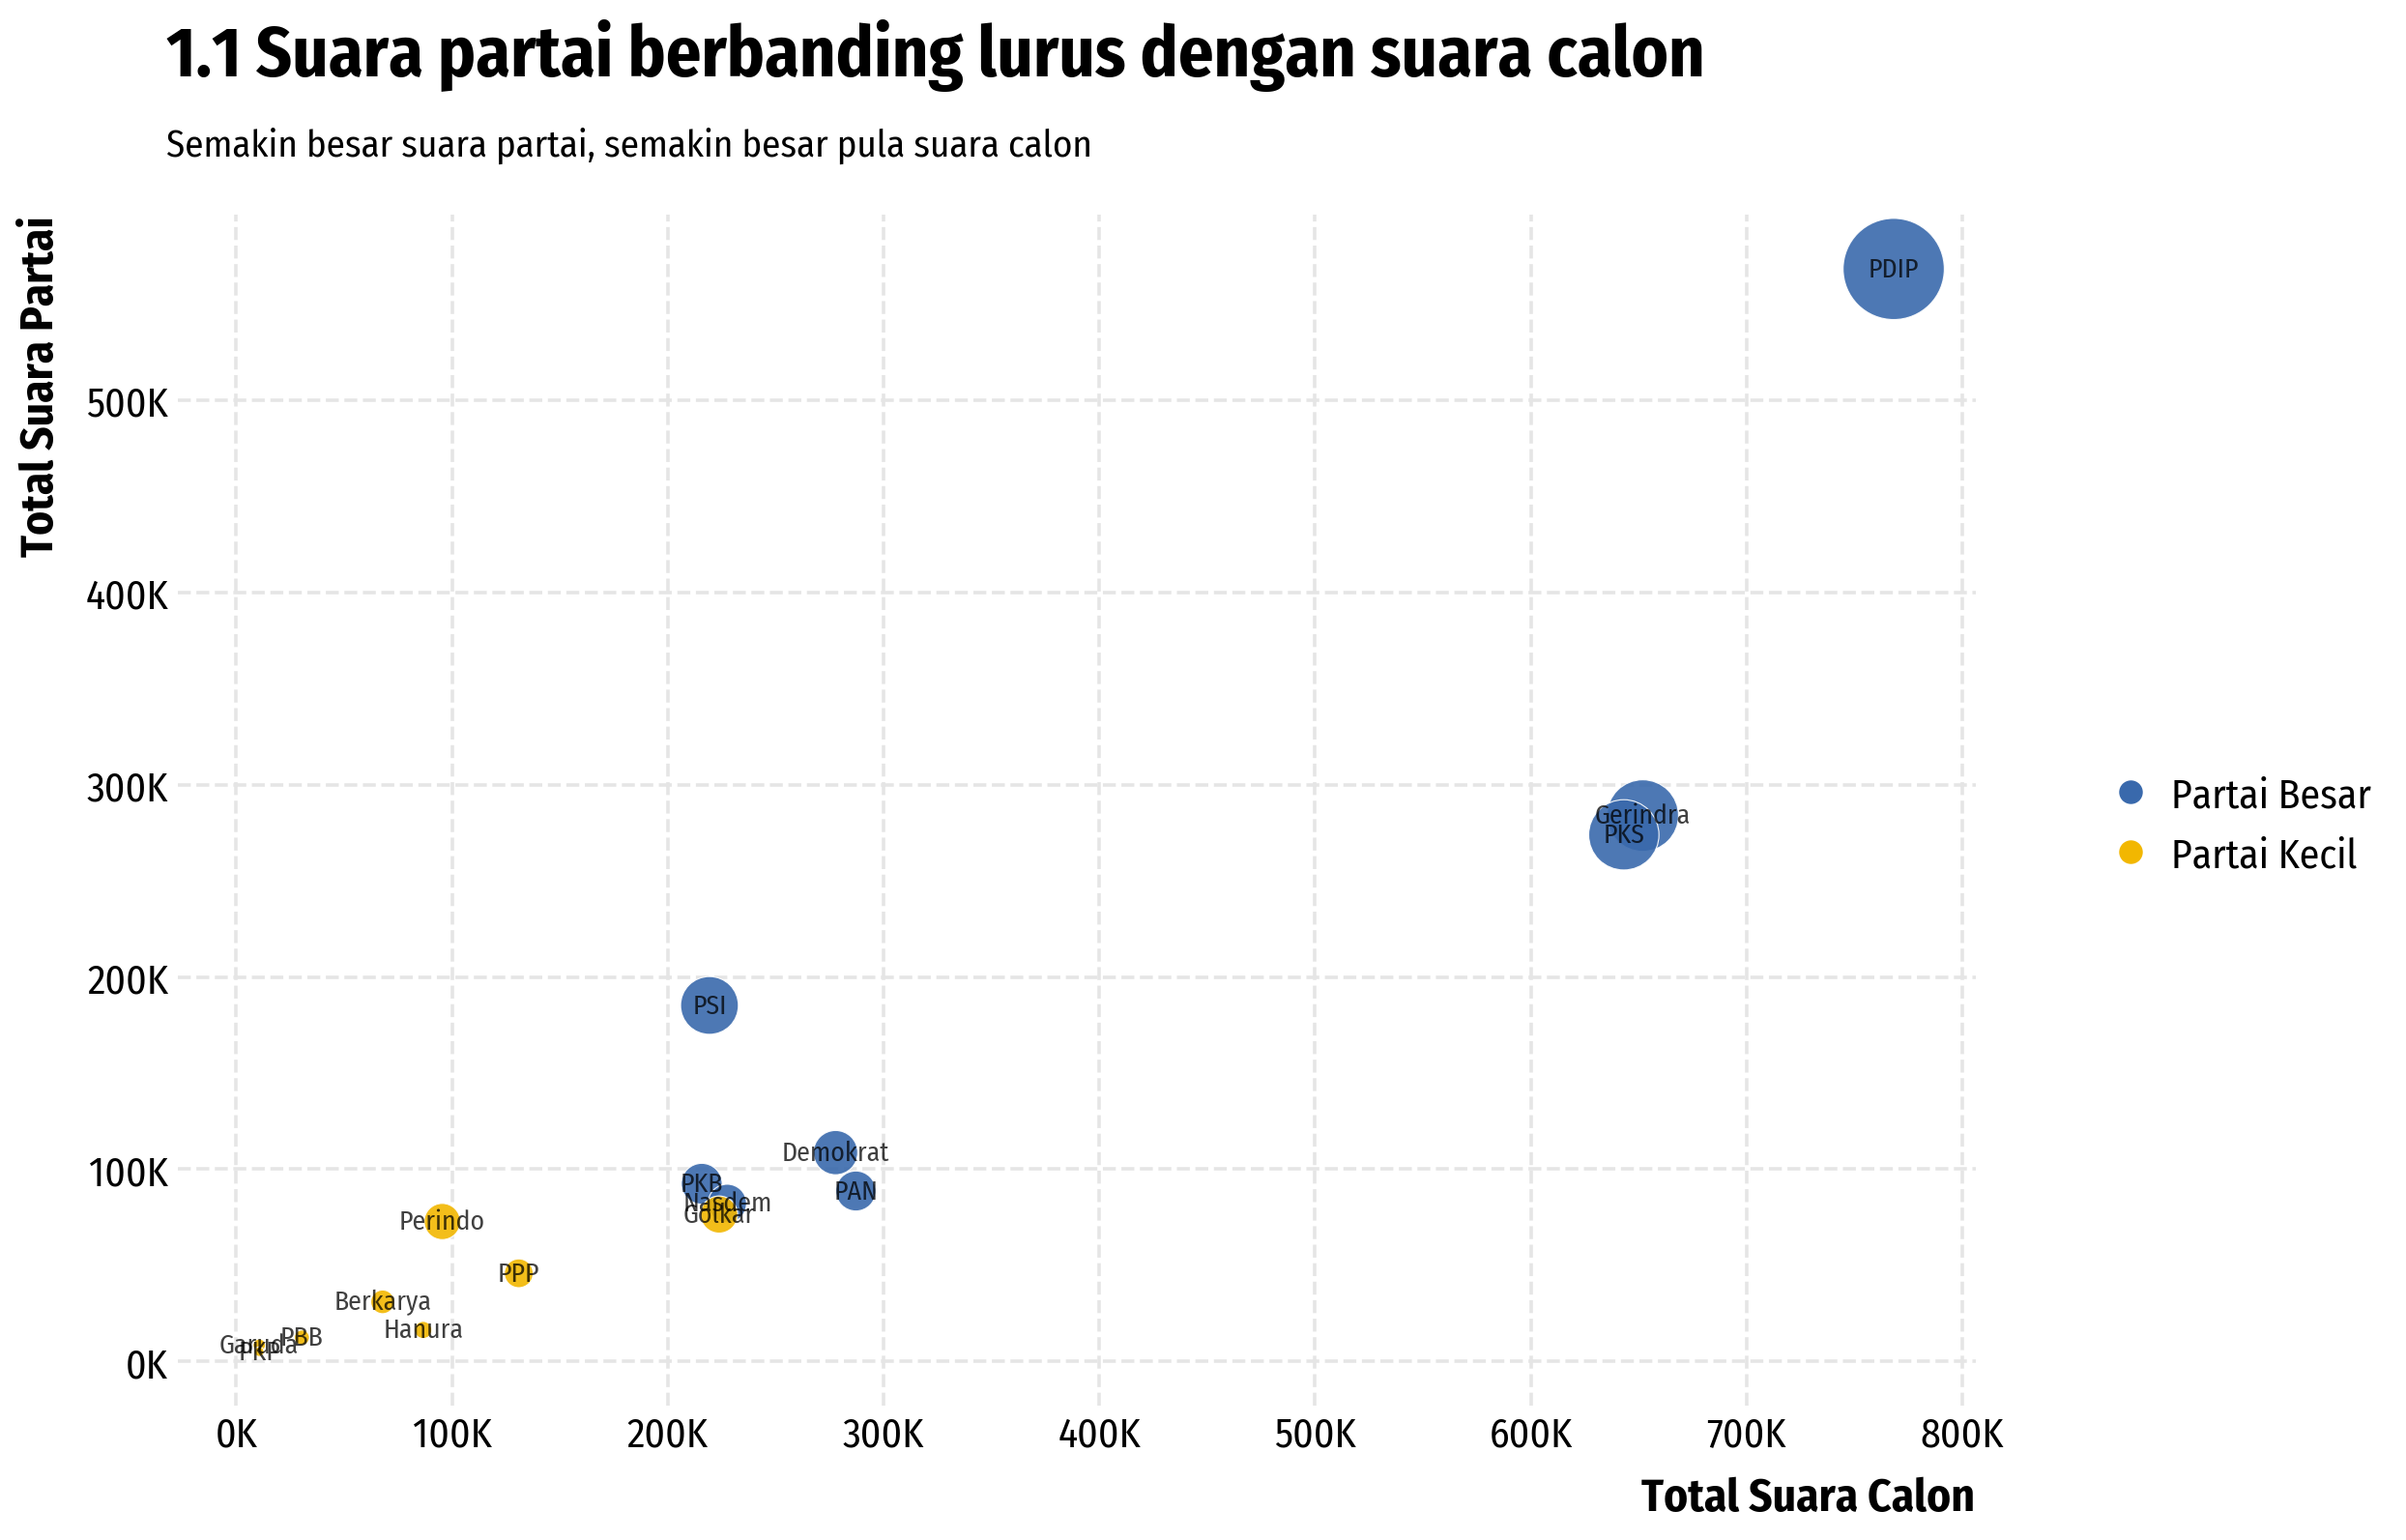

In [107]:
x = "Total Suara Calon"
y = "Total Suara Partai"
f, ax = plt.subplots(figsize=(12, 8), dpi=200)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",)
    sns.scatterplot(
        x=x,
        y=y,
        hue="Ukuran Partai",
        data=data_partai_full,
        alpha=0.9,
        s=data_partai_full["Total Suara Partai"] / 400,
        palette=cmaps.bold[2:5]._colors
    )
opinionated.add_legend(title="")
opinionated.set_title_and_suptitle(
    "1.1 Suara partai berbanding lurus dengan suara calon",
    "Semakin besar suara partai, semakin besar pula suara calon",
)
module.label_point(
    data_partai_full[x], data_partai_full[y], data_partai_full["Partai"], plt.gca()
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if max(data_partai_full[x]) >= 1000: 
        xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)
    if max(data_partai_full[y]) >= 1000: 
        ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)

plt.show()

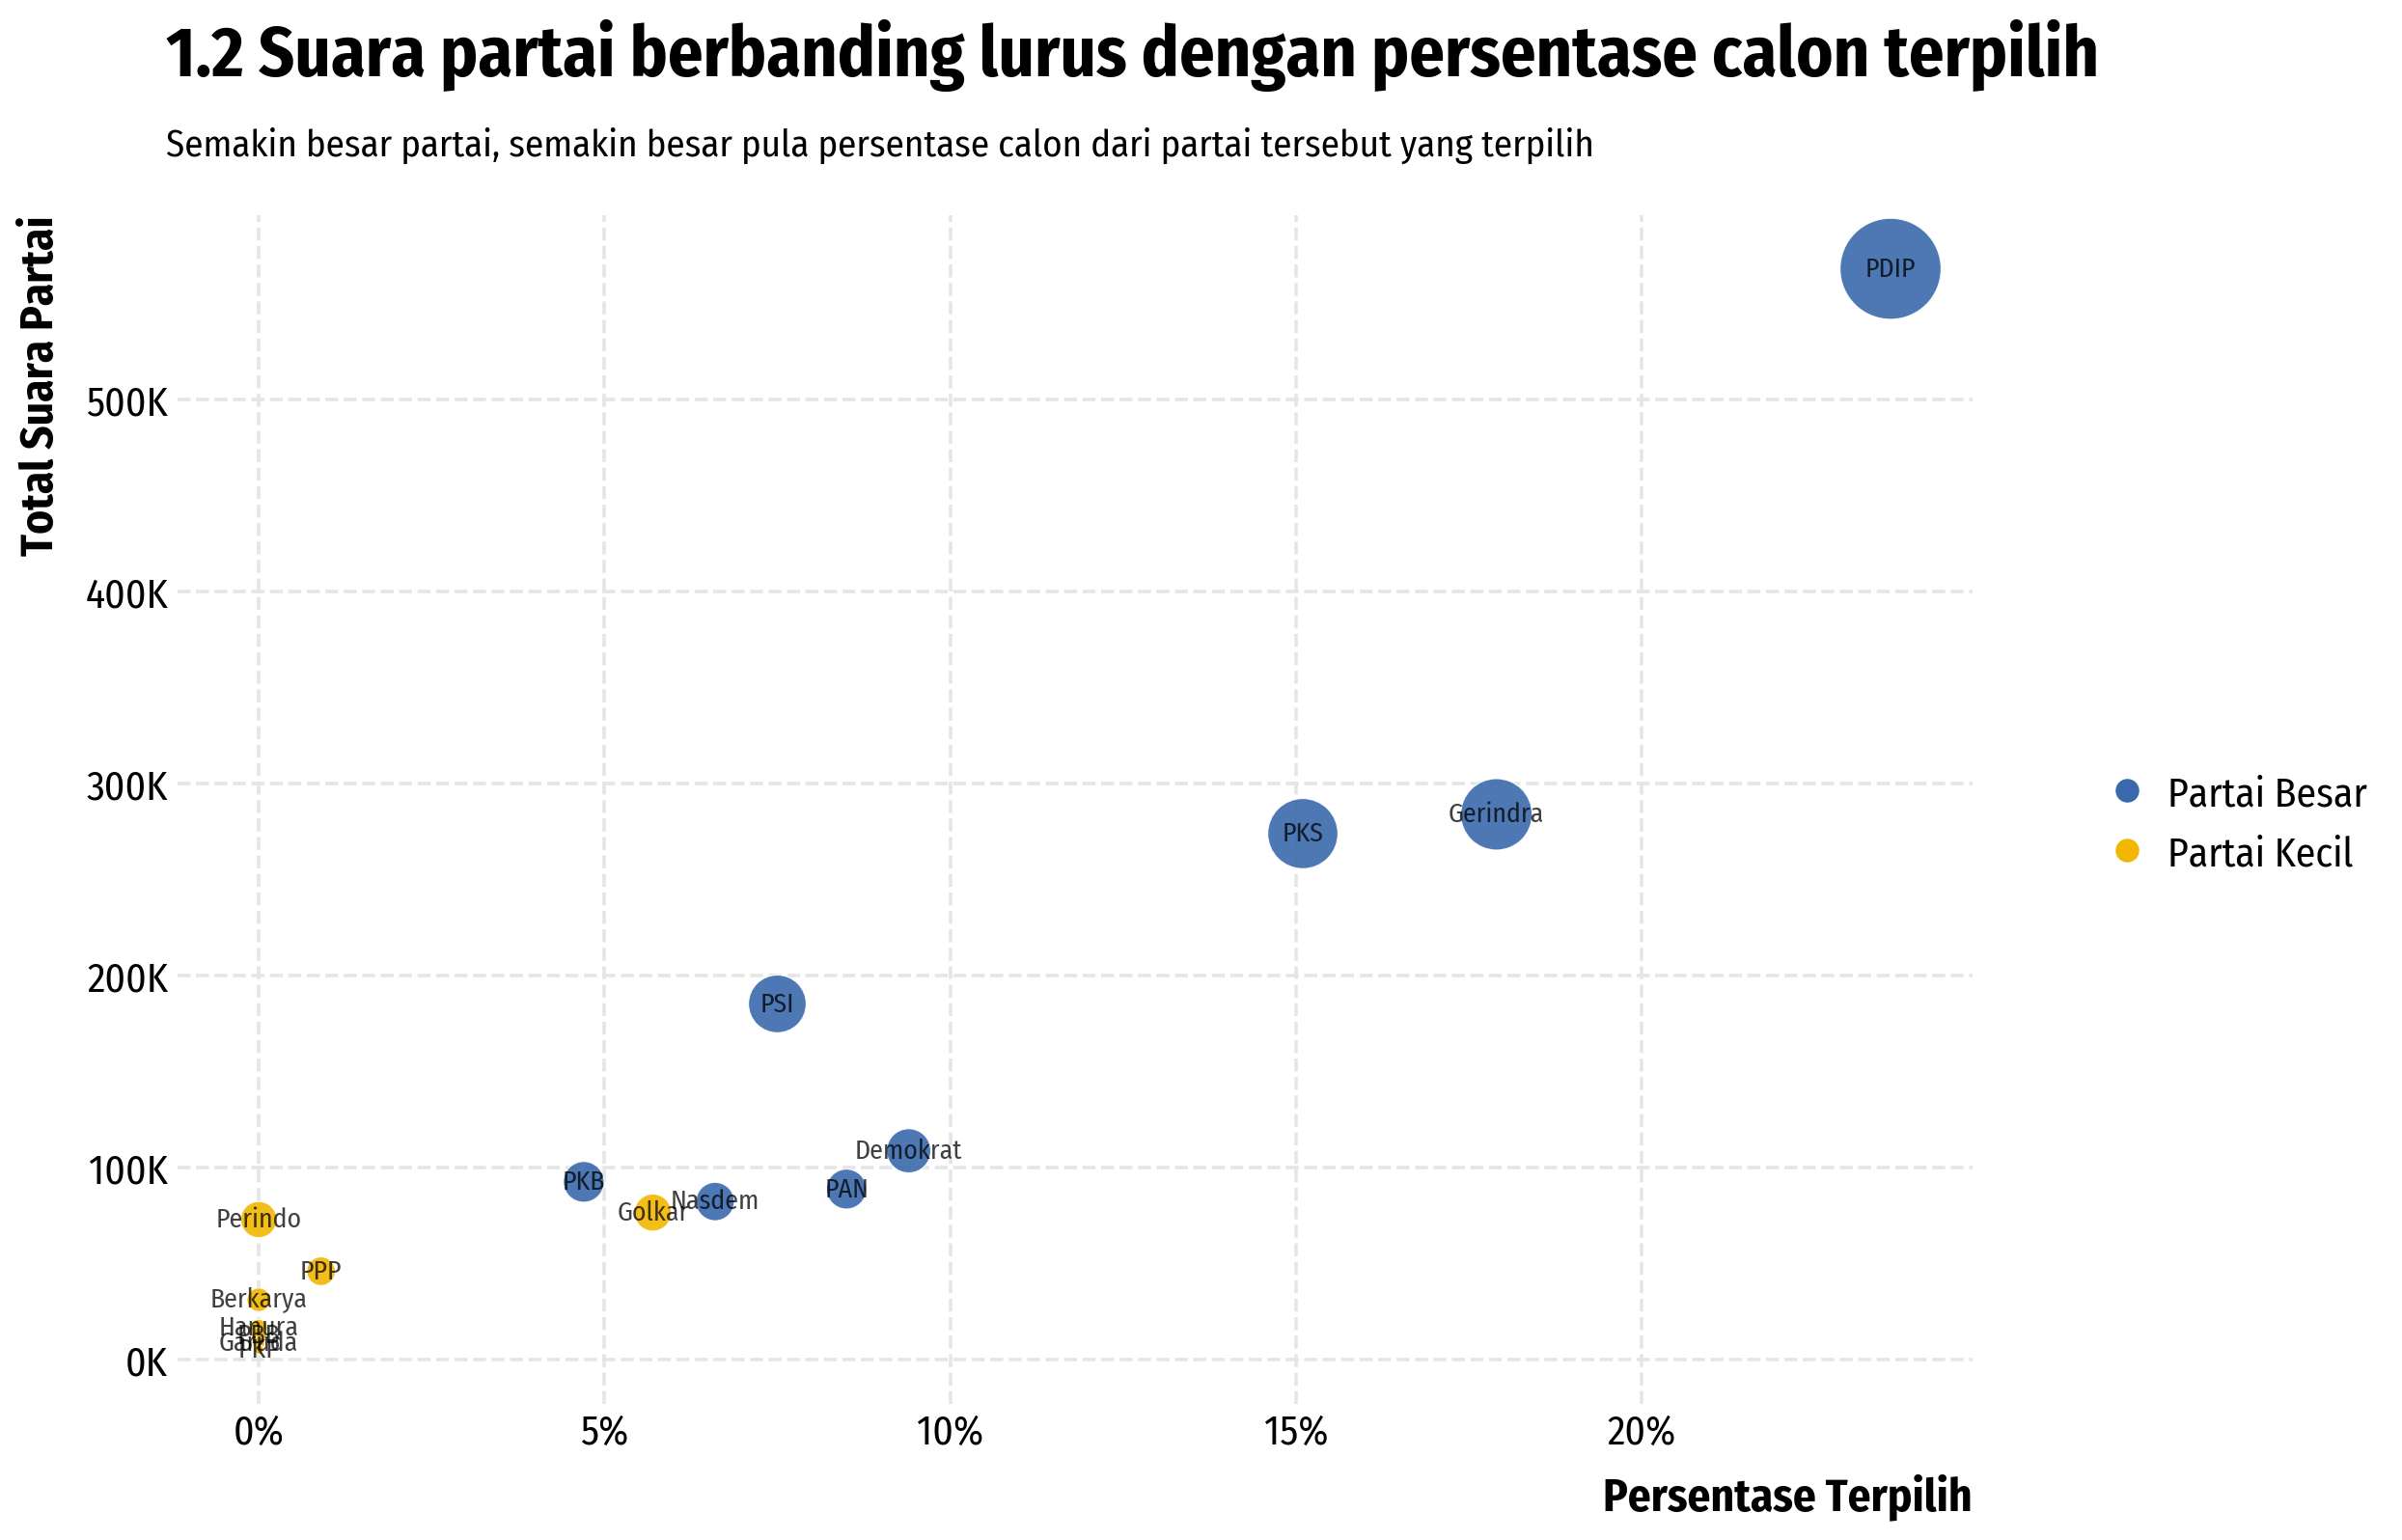

In [108]:
x = "Persentase Terpilih"
y = "Total Suara Partai"
f, ax = plt.subplots(figsize=(12, 8), dpi=200)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sns.scatterplot(
        x=x,
        y=y,
        hue="Ukuran Partai",
        data=data_partai_full,
        alpha=0.9,
        s=data_partai_full["Total Suara Partai"] / 400,
        palette=cmaps.bold[2:5]._colors
    )
opinionated.add_legend(title="")
opinionated.set_title_and_suptitle(
    "1.2 Suara partai berbanding lurus dengan persentase calon terpilih",
    "Semakin besar partai, semakin besar pula persentase calon dari partai tersebut yang terpilih",
)
module.label_point(
    data_partai_full[x], data_partai_full[y], data_partai_full["Partai"], plt.gca()
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if max(data_partai_full[x]) >= 1000: 
        xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)
    if max(data_partai_full[x]) <= 100: 
        xlabels = ['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()]
        ax.set_xticklabels(xlabels)
    if max(data_partai_full[y]) >= 1000: 
        ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)

plt.show()

In [109]:
data_partai_per_ukuran = (data_partai_full
    .groupby(["Ukuran Partai"])
    .agg(
        jumlah_terpilih=('Jumlah Terpilih', 'sum'),
        persentase_terpilih=('Persentase Terpilih', 'sum'),
    )
    .reset_index()
    .rename(columns=lambda c: c.replace("_", " ").title())
)

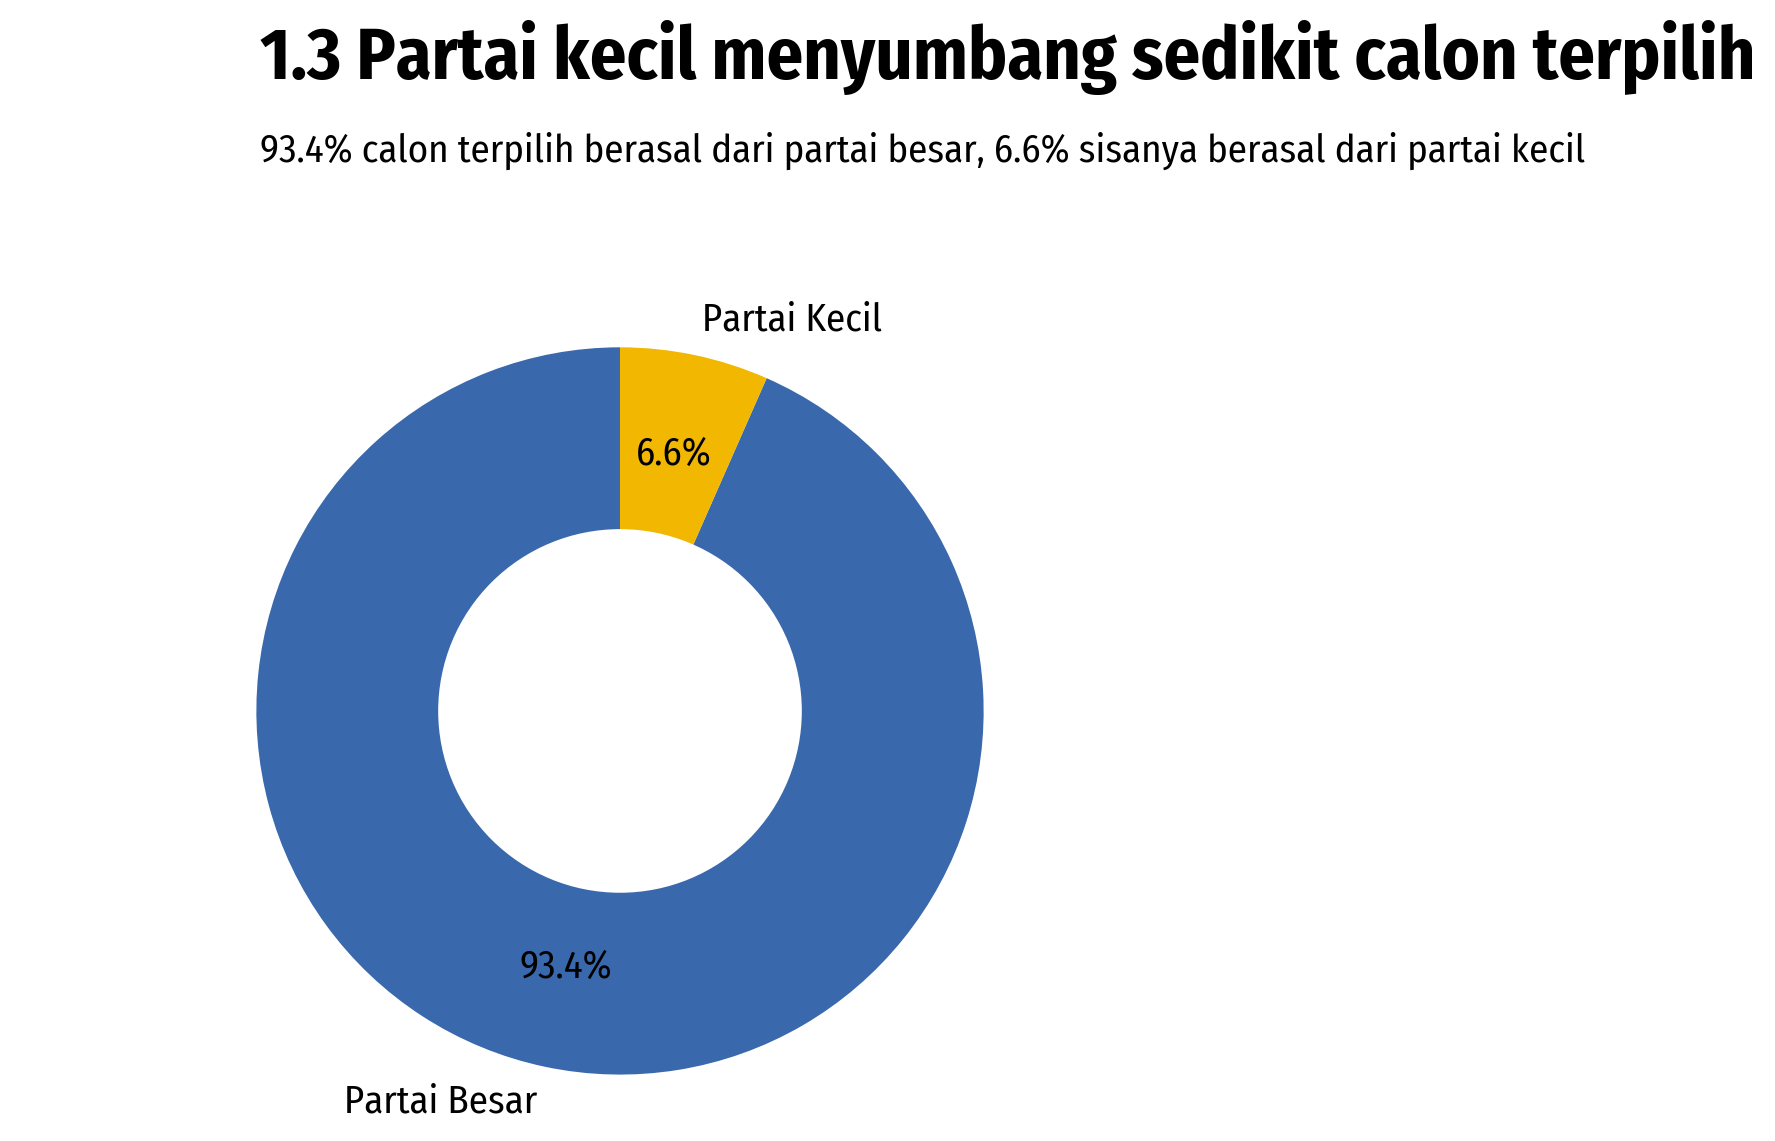

In [110]:
module.create_donut(
    data_partai_per_ukuran["Persentase Terpilih"],
    data_partai_per_ukuran["Ukuran Partai"],
    "1.3 Partai kecil menyumbang sedikit calon terpilih",
    "93.4% calon terpilih berasal dari partai besar, 6.6% sisanya berasal dari partai kecil",
)

Dilihat dari perspektif lain, jika kita bergabung dengan partai kecil, kemungkinan kita terpilih hanya 0.91%, amat sangat kecil.

In [111]:
(data_partai_full
    .groupby(["Ukuran Partai"])
    .agg(
        jumlah_calon=('Jumlah Calon', 'sum'), 
        jumlah_terpilih=('Jumlah Terpilih', 'sum'),
    )
    .assign(kemungkinan_terpilih_dalam_persen=lambda df_: (df_['jumlah_terpilih']
                                              .div(df_['jumlah_calon']))
                                              .mul(100)
                                              .round(2)
                                              )
    .reset_index()
    .rename(columns=lambda c: c.replace("_", " ").title())
)

,Ukuran Partai,Jumlah Calon,Jumlah Terpilih,Kemungkinan Terpilih Dalam Persen
0,Partai Besar,848,99,11.67
1,Partai Kecil,767,7,0.91


### 1.4 Kesimpulan

**<span style="color: purple;">Bergabung dengan partai besar jauh lebih menguntungkan daripada bergabung dengan partai kecil</span>**. Dengan bergabung dengan partai besar, calon hampir pasti akan mendapatkan jauh lebih banyak suara dibandingkan jika calon bergabung dengan partai kecil. Efek dari hal ini, kemungkinan calon terpilih akan naik.

Salah satu alasan utama untuk ini adalah fanatisme pemilih dalam pemilihan umum. **<span style="color: purple;">Dalam konteks pemilihan umum, pengaruh partai jauh lebih dominan dibandingkan dengan pengaruh calon.</span>** Dengan kata lain, masyarakat cenderung lebih "mengikuti partai" daripada "mengikuti calon."

Menurut temuan dari Survey Indikator Politik Indonesia dalam makalah berjudul "Efek Popularitas Calon Legislatif Terhadap Elektabilitas Partai Jelang Pemilu 2014":
> - Secara umum, **<span style="color: purple;">hasil akhir pemilu sangat ditentukan oleh kekuatan partai</span>**. Para calon hanya sedikit pengaruhnya.
> - Hasil survei tahun 2013 ini konsisten dengan temuan survei tahun 2009. **<span style="color: purple;">Calon memiliki kontribusi terhadap suara partai, namun kontribusinya sangat kecil</span>** bila dibandingkan kekuatan partai itu sendiri.
> - Para calon pada umumnya sangat bergantung pada kekuatan partai. **<span style="color: purple;">Sebagian besar calon legislatif menumpang popularitas partainya</span>**.

Referensi: [Survey Indikator Politik Indonesia - Efek Popularitas Calon Legislatif Terhadap Elektabilitas Partai Jelang Pemilu 2014](https://www.indikator.co.id/uploads/20131014105703.20130730171101.INDIKATOR_Rilis_Survei_Efek_Calon_Terhadap_Partai.pdf)


---

## 2. Apakah Mungkin Seorang Calon Terpilih saat Calon tsb. Berasal dari Partai Kecil?

In [112]:
data_partai_full.loc[data_partai_full["Ukuran Partai"] == "Partai Kecil"]

,Partai,Jumlah Calon,Jumlah Terpilih,Persentase Terpilih,Total Suara Calon,Total Suara Partai,Ukuran Partai
8,Golkar,106,6,5.7,223805,76441,Partai Kecil
9,Perindo,106,0,0.0,95483,72813,Partai Kecil
10,PPP,106,1,0.9,130948,45887,Partai Kecil
11,Berkarya,106,0,0.0,67833,31044,Partai Kecil
12,Hanura,106,0,0.0,86656,16417,Partai Kecil
13,PBB,106,0,0.0,30439,12513,Partai Kecil
14,Garuda,60,0,0.0,10688,8517,Partai Kecil
15,PKP,71,0,0.0,10635,5130,Partai Kecil


Bisa kita lihat dari tabel di atas, hanya ada 7 calon terpilih yang berasal dari partai kecil: 
- 6 calon terpilih dari partai Golkar
- 1 calon terpilih dari partai PPP

Walaupun demikian, untuk partai Golkar, walaupun suara partai dibawah median, namun partai Golkar merupakan partai kecil dengan suara terbanyak. Jarak suara antara partai Golkar dengan partai besar terendah yaitu Nasdem hanya 5.761 suara, jumlah yang relatif kecil mengingat kedua partai ini masing-masing meraup sekitar 80.000 suara.

In [113]:
(data_partai_full
    .loc[data_partai_full["Partai"].isin(['Nasdem', 'Golkar'])]
)

,Partai,Jumlah Calon,Jumlah Terpilih,Persentase Terpilih,Total Suara Calon,Total Suara Partai,Ukuran Partai
7,Nasdem,106,7,6.6,227588,82202,Partai Besar
8,Golkar,106,6,5.7,223805,76441,Partai Kecil


Karena itu, kita akan melihat case outlier yang sesungguhnya: 1 calon terpilih dari partai PPP.

### 2.1 Penelusuran Terhadap 1 Calon Terpilih dari Partai PPP

In [114]:
(df
    .loc[(df['partai'] == 'PPP') & (df['terpilih'] == 1)]
    .rename(columns=lambda c: c.replace("_", " ").title())
)

,Dapil No,Dapil Nama,No Urut,Nama,Vote,Partai,Partai Vote,Terpilih
855,6,Jakarta Timur,1,"Matnoor Tindoan, S.H.",21553,PPP,6238,1


Menagapa 1 calon ini bisa terpilih? Mari kita lihat performa PPP di dapil nomor 6.

In [115]:
(df
    .loc[(df['partai'] == 'PPP') & (df['dapil_no'] == 6)]
    .rename(columns=lambda c: c.title().replace("_", " "))
) 

,Dapil No,Dapil Nama,No Urut,Nama,Vote,Partai,Partai Vote,Terpilih
855,6,Jakarta Timur,1,"Matnoor Tindoan, S.H.",21553,PPP,6238,1
856,6,Jakarta Timur,2,Hj. Neneng Radhiah,1566,PPP,6238,0
857,6,Jakarta Timur,3,"Ahmad Guntur, S.E.",759,PPP,6238,0
858,6,Jakarta Timur,4,Aris Sandi Rosid,381,PPP,6238,0
859,6,Jakarta Timur,5,Mery Daryanti,179,PPP,6238,0
860,6,Jakarta Timur,6,Hj. Nurzaidah,597,PPP,6238,0
861,6,Jakarta Timur,7,Neni Sutisna,267,PPP,6238,0
862,6,Jakarta Timur,8,"Wardi, S.Ag., M.Si.",170,PPP,6238,0
863,6,Jakarta Timur,9,Junaedi,196,PPP,6238,0
864,6,Jakarta Timur,10,Muhammad Hatta,492,PPP,6238,0


Jika kita lihat dari performa PPP di dapil 6, calon terpilih atas nama Matnoor Tindoan, S.H. merupakan outlier, dalam artian calon ini outperform calon lain dari PPP dengan sangat jauh. Bisa kita lihat bahwa suara yang didapat calon ini adalah 21.553, sedangkan calon dengan suara terbanyak kedua, Hj. Neneng Radhiah, hanya mendapat 1.566 suara, 10x lebih kecil.

Dilihat dari sisi lain, suara yang didapatkan Matnoor Tindoan, S.H. merupakan 82% suara yang didapat calon PPP di dapil tersebut.

In [116]:
(df
    .loc[(df["partai"] == "PPP") & (df["dapil_no"] == 6)]
    .assign(
        nama=lambda df_: np.where(
            df_["nama"] == "Matnoor Tindoan, S.H.",
            "Matnoor Tindoan, S.H.",
            "Calon Lain dari PPP di Dapil 6",
        )
    )
    .groupby("nama")
    .agg(vote=("vote", "sum"))
    .reset_index()
    .sort_values("vote", ascending=False)
    .assign(
        persentase_vote=lambda df_: df_["vote"].div(df_["vote"].sum()).mul(100).round(2)
    )
    .rename(columns=lambda c: c.title().replace("_", " "))
)

,Nama,Vote,Persentase Vote
1,"Matnoor Tindoan, S.H.",21553,82.39
0,Calon Lain dari PPP di Dapil 6,4607,17.61


Secara rata-rata, calon lain dari seluruh partai di dapil 6 hanya mendapatkan 2.376 suara, 10x lebih kecil dari suara yang didapatkan Matnoor Tindoan, S.H.

In [117]:
(df
    .loc[(df["dapil_no"] == 6)]
    .assign(
        nama=lambda df_: np.where(
            df_["nama"] == "Matnoor Tindoan, S.H.",
            "Matnoor Tindoan, S.H.",
            "Calon lain dari seluruh partai di dapil 6",
        )
    )
    .groupby("nama")
    .agg(vote=("vote", "mean"))
    .astype(int)
    .reset_index()
    .sort_values("vote", ascending=False)
    .rename(columns=lambda c: c.title().replace("_", " "))
)

,Nama,Vote
1,"Matnoor Tindoan, S.H.",21553
0,Calon lain dari seluruh partai di dapil 6,2376


Bahkan, Matnoor Tindoan, S.H. merupakan calon dengan suara terbesar kedua di dapil 6, walaupun berasal dari partai kecil.

In [118]:
(df
    .loc[(df['dapil_no'] == 6)]
    .sort_values('vote', ascending=False)
    .head(10)
    .drop(columns=['partai_vote', 'terpilih'])
    .rename(columns=lambda c: c.title().replace('_', ' '))
    .reset_index(drop=True)
)

,Dapil No,Dapil Nama,No Urut,Nama,Vote,Partai
0,6,Jakarta Timur,8,Hj. Umi Kulsum,27606,PKS
1,6,Jakarta Timur,1,"Matnoor Tindoan, S.H.",21553,PPP
2,6,Jakarta Timur,7,Drs. K.H. Muhammad Thamrin,16767,PKS
3,6,Jakarta Timur,1,H. Misan Samsuri,16573,Demokrat
4,6,Jakarta Timur,1,Syarif,15517,Gerindra
5,6,Jakarta Timur,1,H. Karyatin Subiyantoro,12572,PKS
6,6,Jakarta Timur,1,"Dr. Ir. H. Rasyidi H. Y., M.M., C.P.A., M.A.",11871,PDIP
7,6,Jakarta Timur,1,Panel Barus,10547,Nasdem
8,6,Jakarta Timur,1,"Dr. Muhammad Guntur, S.E., M.M.",10067,Hanura
9,6,Jakarta Timur,4,Bambang Kusumanto,9707,PAN


### 2.2 Kesimpulan

**<span style="color: purple;">Walapun ada case dimana calon dari partai kecil terpilih, kemungkinan terpilihnya calon dari partai kecil tetap sangat tipis.</span>**

Matnoor Tindoan, S.H. dapat terpilih walaupun berasal dari partai kecil karena secara individu, dia outperform seluruh calon lain di dapil 6 (kecuali Hj. Umi Kulsum). Sulit untuk mengetahui kenapa Matnoor bisa outperform calon lain hanya dari data ini, karena popularitas Matnoor Tindoan, S.H. berasal dari faktor eksternal. Namun, saya yakin bahwa salah satu faktor adalah fakta bahwa sebelumnya, Matnoor Tindoan, S.H. sudah 2x terpilih sebagai DPRD di dapil yang sama (sumber: [Republik Merdeka Jakarta](https://www.rmoldkijakarta.id/akhirnya-ppp-raih-kursi-dprd-lewat-matnoor-tindoan)). Hal ini mendandakan bahwa:
1. Matnoor sudah memiliki basis pendukung yang kuat di dapil 6.
2. Matnoor memiliki waktu selama 2 periode untuk memperkuat basis dukungannya di dapil 6.


---

## 3. Bagaimana Performa Partai di Tiap Dapil?

In [119]:
data = (df
    .groupby(["dapil_no", "dapil_nama", "partai"])
    .agg(
        vote_untuk_partai=("partai_vote", "mean"),
        vote_untuk_calon=("vote", "sum"),
    )
    .reset_index()
    .melt(id_vars=["dapil_no", "dapil_nama", "partai"])
    .assign(
        variable=lambda df_: df_["variable"].str.replace("_", " ").str.title()
    )
)

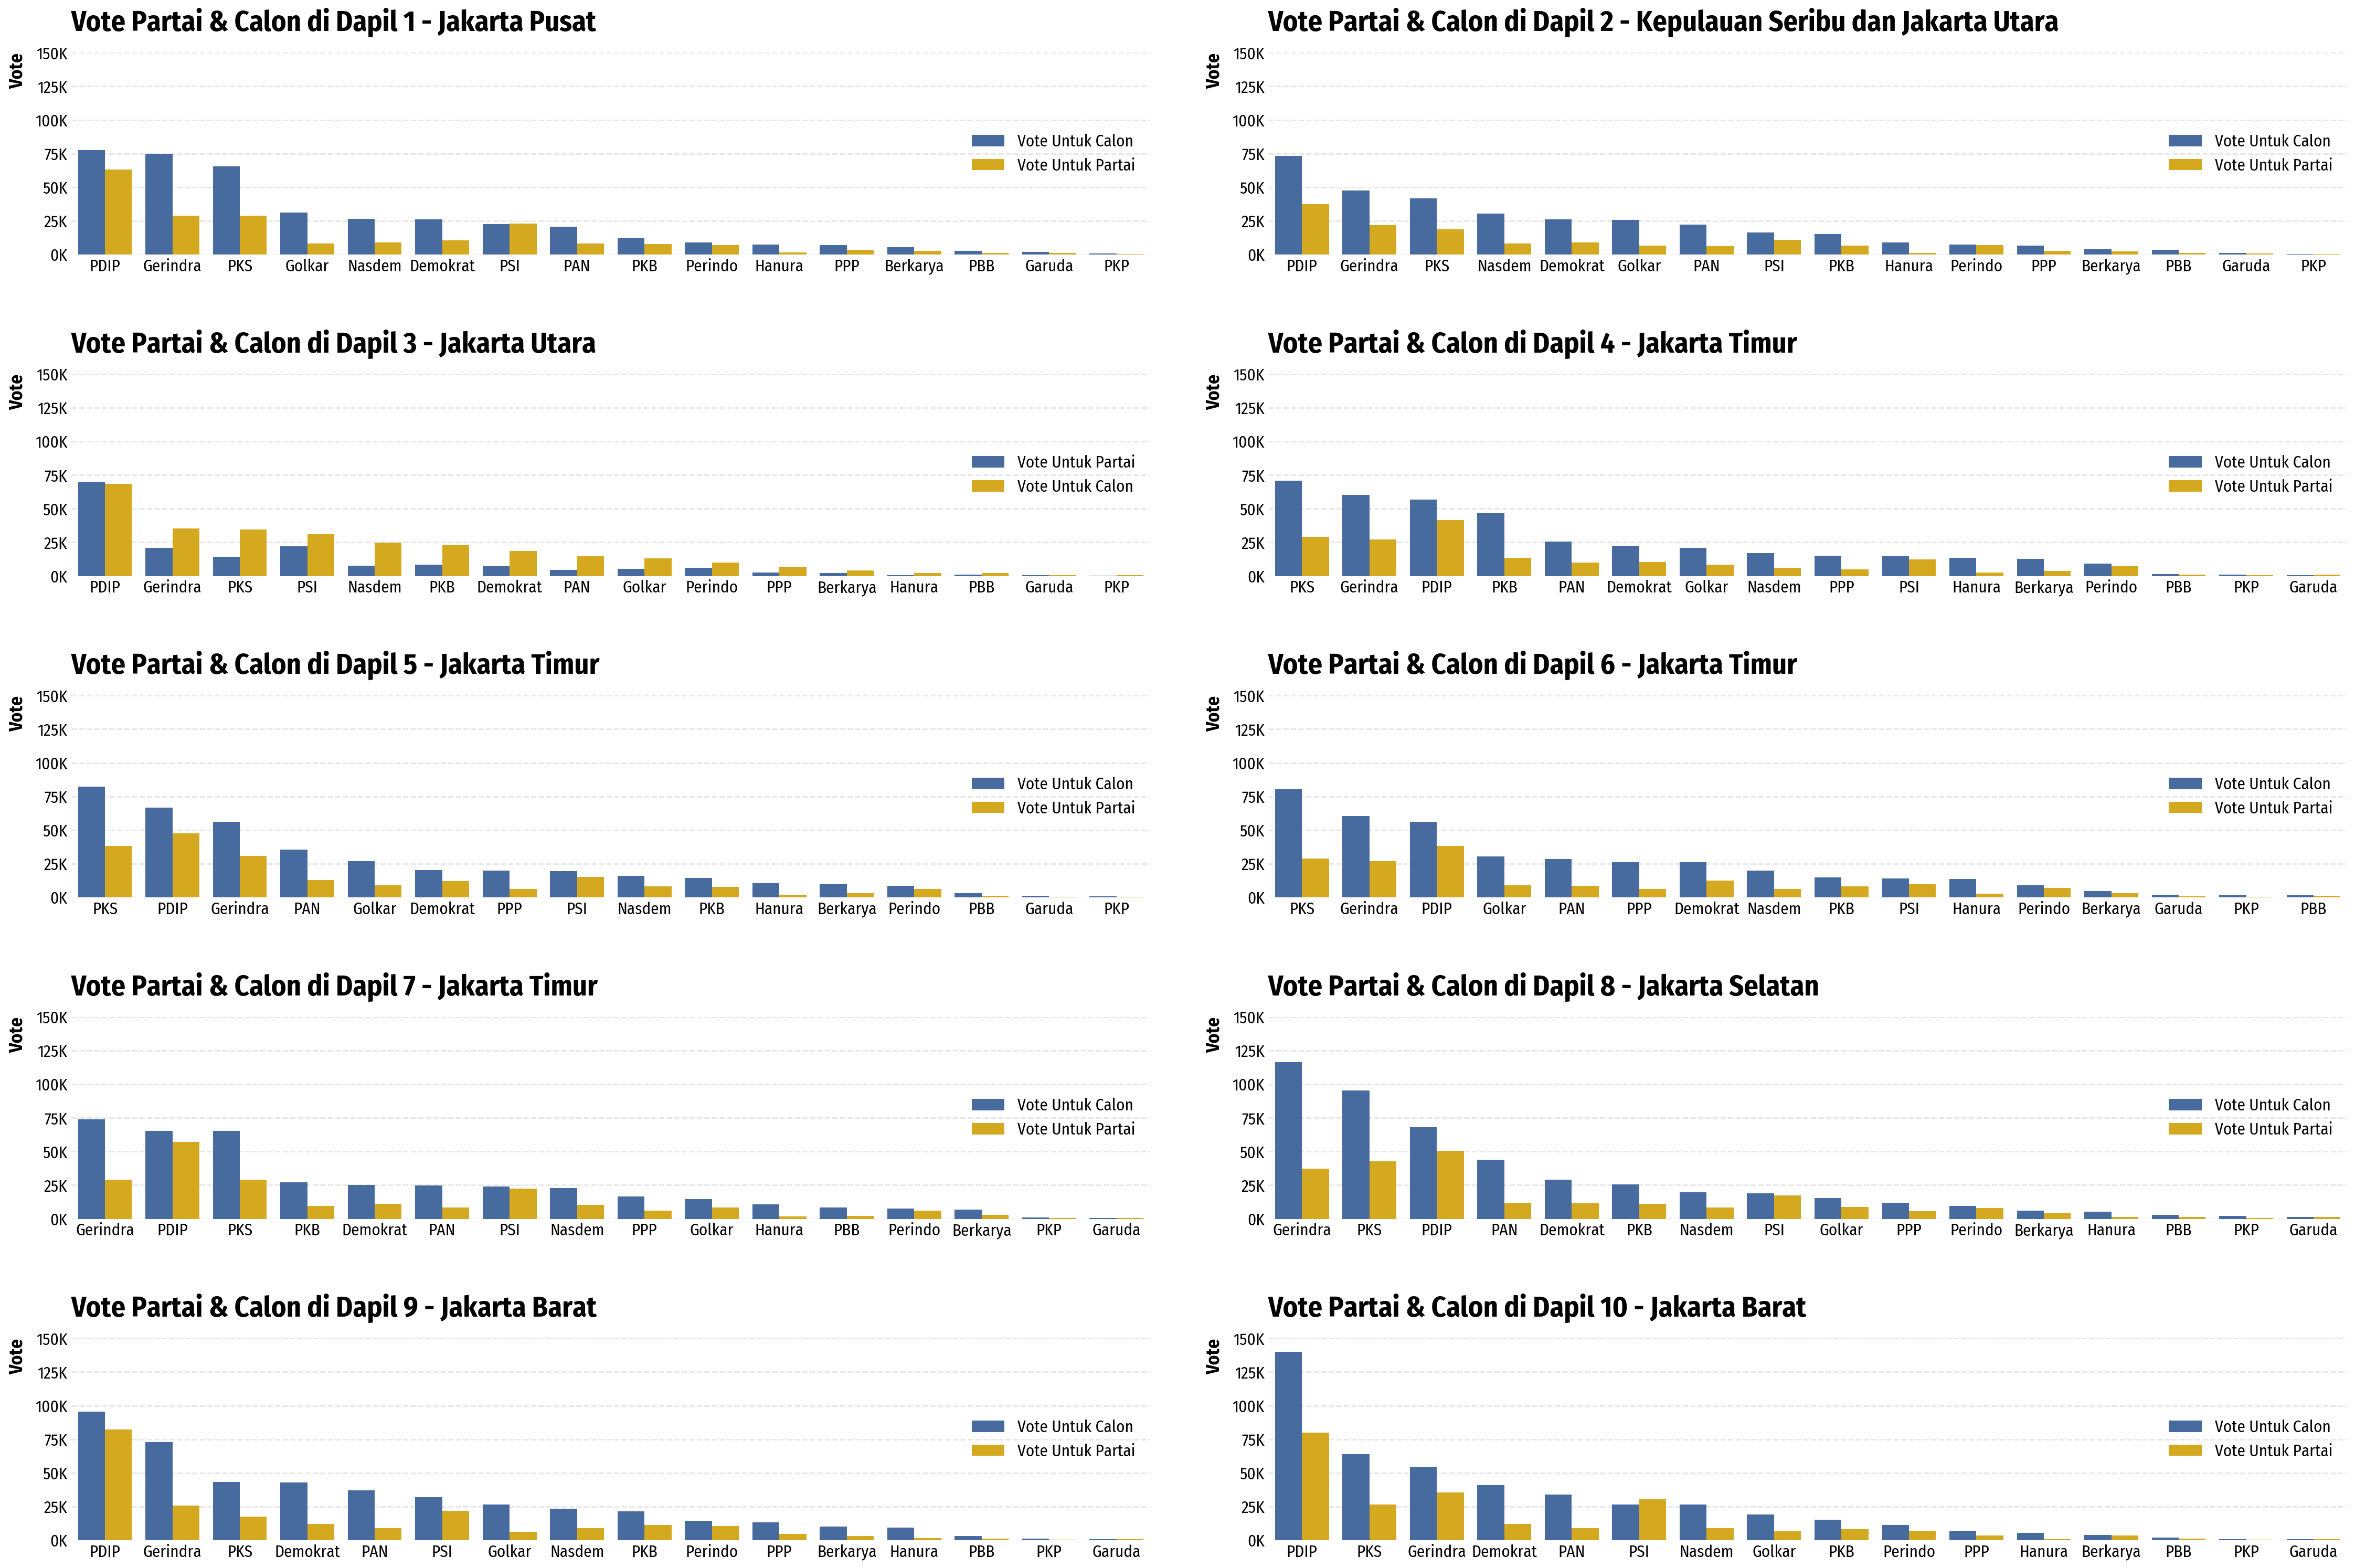

In [120]:
fig = plt.figure(figsize=(30, 20), dpi=150)
for i in range(1, 11, 1):
    ax = plt.subplot(5, 2, i)
    data_per_dapil = data.loc[data['dapil_no'] == i].sort_values("value", ascending=False)
    sns.barplot(
        data=data_per_dapil, 
        x="partai", 
        y="value",
        hue="variable", 
        palette=cmaps.bold[2:5]._colors,
    )
    ax.legend(title="")
    ax.set_ylim(0, 150_000)
    ax.set_xlabel("")
    ax.set_ylabel("Vote")
    ax.set_title(f"Vote Partai & Calon di Dapil {i} - {data_per_dapil['dapil_nama'].unique()[0]}", fontweight="bold")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        if max(data_per_dapil['value']) >= 1000: 
            ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
            ax.set_yticklabels(ylabels)
        else:
            pass

plt.tight_layout(w_pad=5, h_pad=5, pad=1)
plt.show()

Dari chart di atas, bisa kita lihat bahwa tidak ada partai yang kuat di semua dapil. Walaupun demikian, top 3 partai di semua dapil selalu terdiri dari PDIP, Gerindra dan PKS. 

Chart ini bisa digunakan sebagai pedoman untuk memilih dapil dan partai sesuai kekuatan partai di tiap dapil.

---

## 4. Apakah Nomor Urut Berpengaruh terhadap Terpilihnya Calon?

In [121]:
(df
    .groupby(["partai", "no_urut"])
    .agg(jumlah_calon=("no_urut", "size"))
    .reset_index()
    .pivot(index="partai", columns="no_urut")
    .droplevel(0, axis=1)
    .rename_axis("No Urut", axis=1)
    .rename_axis("Partai", axis=0)
    .fillna(0)
    .astype(int)
)

No Urut,1,2,3,4,5,6,7,8,9,10,11,12
Partai,,,,,,,,,,,,
Berkarya,10,10,10,10,10,10,10,10,10,8,4,4
Demokrat,10,10,10,10,10,10,10,10,10,8,4,4
Garuda,10,10,10,9,8,5,3,3,1,1,0,0
Gerindra,10,10,10,10,10,10,10,10,10,8,4,4
Golkar,10,10,10,10,10,10,10,10,10,8,4,4
Hanura,10,10,10,10,10,10,10,10,10,8,4,4
Nasdem,10,10,10,10,10,10,10,10,10,8,4,4
PAN,10,10,10,10,10,10,10,10,10,8,4,4
PBB,10,10,10,10,10,10,10,10,10,8,4,4


Tabel di atas merupakan jumlah calon per nomor urut per partai. Bisa kita lihat, semua partai memiliki masing masing 
- 10 calon dengan nomor urut 1-9
- 8 calon dengan nomor urut 10
- 4 calon dengan nomor urut 11-12 

(kecuali partai Garuda dan partai PKP yang memiliki jumlah calon yang lebih sedikit).

Karena jumlah calon per nomor urut per partai sama, kita bisa mencari tahu, **apakah nomor urut berpengaruh terhadap terpilihnya calon?**

Untuk mencari tahu, kita akan melihat berapapa jumlahh calon dan jumlah calon terpilih per nomor urut. Kita akan menghiraukan partai Garuda dan partai PKP karena memiliki lebih sedikit calon, dan menghiraukan nomor urut 10-12 karena memiliki lebih sedikit calon juga.

In [122]:
(df
    .loc[~df["partai"].isin(["Garuda", "PKP"])]
    .loc[df["no_urut"] <= 9]
    .groupby(["partai", "no_urut"])
    .agg(jumlah_calon=("no_urut", "size"))
    .reset_index()
    .pivot(index="partai", columns="no_urut")
    .droplevel(0, axis=1)
    .rename_axis("No Urut", axis=1)
    .rename_axis("Partai", axis=0)
    .fillna(0)
    .astype(int)
)

No Urut,1,2,3,4,5,6,7,8,9
Partai,,,,,,,,,
Berkarya,10,10,10,10,10,10,10,10,10
Demokrat,10,10,10,10,10,10,10,10,10
Gerindra,10,10,10,10,10,10,10,10,10
Golkar,10,10,10,10,10,10,10,10,10
Hanura,10,10,10,10,10,10,10,10,10
Nasdem,10,10,10,10,10,10,10,10,10
PAN,10,10,10,10,10,10,10,10,10
PBB,10,10,10,10,10,10,10,10,10
PDIP,10,10,10,10,10,10,10,10,10


In [123]:
data_no_urut = (df
    .loc[(df['terpilih'] == 1) & ~(df['partai'].isin(['Garuda', 'PKP'])) & (df['no_urut'] <= 9)]
    .groupby('no_urut')
    .agg(jumlah_calon_terpilih=('no_urut', 'size'))
    .reset_index()
    .assign(persentase_dari_total_terpilih=lambda df_: (df_['jumlah_calon_terpilih']
                                               .div(df_['jumlah_calon_terpilih'].sum())
                                               .mul(100)
                                               .round(2)
                                               )
    )
    .rename(columns=lambda c: c.replace('_', ' ').title())
    .set_index('No Urut')
)
data_no_urut

,Jumlah Calon Terpilih,Persentase Dari Total Terpilih
No Urut,,
1,53,51.96
2,14,13.73
3,4,3.92
4,11,10.78
5,7,6.86
6,1,0.98
7,4,3.92
8,7,6.86
9,1,0.98


Bisa kita lihat bahwa dari semua calon yang terpilih, 50% adalah calon dengan nomor urut 1. Kemudian, 13% adalah calon dengan nomor urut 2, 10% adalah calon dengan nomor urut 4.

Ada hasil menarik yang kita temukan: 

****<span style="color: purple;">Nomor-nomor kecil terlihat lebih banyak terpilih dibanding nomor nomor besar.</span>****

Apakah nomor-nomor kecil lebih banyak terpilih hanya karena kebetulan?

### 4.1 Apakah nomor-nomor kecil lebih banyak terpilih hanya karena kebetulan?

Untuk menjawab pertanyaan ini, kita akan melakukan tes statistik. Tes statistik yang akan kita gunakan adalah test chi-squared goodness-of-fit. 

Ini adalah hipotesis kita: 
- Hipotesis Nol (H0): Nomor urut kecil lebih banyak terpilih karena kebetulan.
- Hipotesis Alternatif (H1): Nomor urut kecil lebih banyak terpilih bukan karena kebetulan.

Kemudian, ini adalah hasil yang kita harapkan:
- Bila hasil test (p value) di  atas 0.05, maka secara sederhana kita menganggap hipotesis nol benar.
- Bila hasil test (p value) di bawah 0.05, maka secara sederhana kita menganggap hipotesis alternatif benar.

Referensi: https://en.wikipedia.org/wiki/Goodness_of_fit

In [124]:
import scipy.stats as stats

observed = data_no_urut['Jumlah Calon Terpilih'].values
expected = [observed.mean()] * len(observed)

s, p_val = stats.chisquare(f_obs=observed, f_exp=expected)

print(f'    hasil test : p value = {p_val: .50f}')

    hasil test : p value =  0.00000000000000000000000000000000000729929625476284


Hasil dari tes statistik menunjukkan nilai yang jauh di bawah 0.05. Oleh karena itu, kita dapat menyimpulkan bahwa nomor urut kecil lebih sering terpilih bukan karena kebetulan, yang berarti bahwa peluang terpilihnya nomor-nomor kecil lebih tinggi.

Fenomena di mana nomor urut kecil memberikan keuntungan dalam pemilihan telah menjadi subjek penelitian yang luas. Sebagaimana yang dikutip dari MIT Election Data Science Lab:
> Academic research into ballot-order effects has mostly confirmed common-sense beliefs on the subject: that **appearing first increased a candidate’s chances of performing  well in an election**...

Dalam Bahasa Indonesia: 

> Penelitian akademis terhadap efek urutan nomor urut sebagian besar mengkonfirmasi pemahaman umum tentang masalah ini: bahwa **tampil pertama meningkatkan peluang seorang kandidat untuk berhasil dalam pemilihan**...

Menurut opini dari salah satu peneliti, hal ini kemungkinan diakibatkan bahwa mayoritas pemilih memilih partai (sesuai point no. 1 dalam analisis ini) tanpa mengetahui calon. **<span style="color: purple;">Jika tidak mengetahui calon, pemilih akan cenderung memilih calon yang berada di bagian atas (calon dengan nomor urut rendah)</span>**.

Referensi: [MIT: Ballot Order Effect](https://electionlab.mit.edu/research/ballot-order-effects)

### 4.2 Kesimpulan

Berdasarkan hasil tes statistik yang menunjukkan nilai signifikan di bawah 0.05, dapat disimpulkan bahwa nomor urut kecil lebih sering terpilih bukan karena kebetulan, dengan **<span style="color: purple;">peluang terpilihnya nomor-nomor kecil yang lebih tinggi</span>**.

Penelitian akademis dari MIT Election Data Science Lab mengkonfirmasi bahwa **<span style="color: purple;">tampil pertama dalam urutan nomor urut meningkatkan peluang kesuksesan seorang kandidat dalam pemilihan</span>**. Hal ini menunjukkan pentingnya mempertimbangkan urutan nomor urut dalam perencanaan pemilihan.

---

## 5. Bagaimana Metode Perhitungan Pemilu DPRD?

Pemilu DPRD ditentukan dengan metode perhitungan Sainte Lague murni. Untuk melihat bagaimana metode ini bekerja, kita misalkan ada 5 partai yang akan memperebutkan 8 kursi. Masing-masing partai tsb. mendapat:
- Partai A : 100.000 suara
- Partai B : 80.000 suara
- Partai C : 50.000 suara
- Partai D : 20.000 suara
- Partai E : 2.000 suara

Perhitungan Sainte Lague untuk skenario ini adalah sebagai berikut.

![Alt text](image-2.png)

Agar lebih jelas, mari kita lihat perhitungan per ronde dari sudut pandang Partai B.

![Alt text](image-3.png)

- **Ronde 1**: Suara A tertinggi.
- **Ronde 2**: Suara B tertinggi. Suara B dibagi *bilangan ganjil pertama* yaitu 3 karena ini adalah kali *pertama* terpilihnya B.
- **Ronde 3**: Suara C tertinggi.
- **Ronde 4**: Suara A tertinggi.
- **Ronde 5**: Suara B tertinggi. Suara B dibagi *bilangan ganjil kedua* yaitu 5 karena ini adalah kali *kedua* terpilihnya B. 
- **Ronde 6**: Suara A tertinggi.
- **Ronde 7**: Suara C tertinggi. 
- **Ronde 8**: Suara B tertinggi. Suara B dibagi *bilangan ganjil ketiga* yaitu 7 karena ini adalah kali *ketiga* terpilihnya B. 

Hasilnya: 
- Partai A = 3 kursi
- Partai B = 3 kursi
- Partai C = 2 kursi
- Partai D = 0 kursi
- Partai E = 0 kursi


Kemudian dari tiap partai yang mendapat jatah kursi, calon dipilih berdasarkan perolehan suara di masing-masing partai. Artinya:
- Partai A = 3 calon dari partai A dengan suara terbanyak terpilih
- Partai B = 3 calon dari partai B dengan suara terbanyak terpilih
- Partai C = 2 calon dari partai C dengan suara terbanyak terpilih
- Partai D = 0 calon dari partai D dengan suara terbanyak terpilih
- Partai E = 0 calon dari partai E dengan suara terbanyak terpilih

---

## 6. Apakah Metode Perhitungan ini Menguntungkan Partai Besar atau Partai Kecil?

Dalam konteks ini, kita mengarikan untung dan rugi sebagai berikut:
- Untung = suatu partai mendapatkan kursi lebih banyak dari perolehan kursi berdasarkan persentase. Misal harusnya perdasarkan persentase mendapat 3.5 kursi, tapi pada kenyataannya mendapat 4 kursi.
- Rugi = suatu partai mendapatkan kursi lebih sedikit dari perolehan kursi berdasarkan persentase. Misal harusnya perdasarkan persentase mendapat 3.5 kursi, tapi pada kenyataannya mendapat 3 kursi.

### 6.1 Dengan Skenario Imaginer

Untuk menjawab pertanyaan ini, mari kita lihat kembali hasil percobaan skenario pemilu di atas.

- Partai A : 100.000 suara
- Partai B : 80.000 suara
- Partai C : 50.000 suara
- Partai D : 20.000 suara
- Partai E : 2.000 suara

Total suara dari semua partai = 252.000 suara

Dari jumlah ini, makan relatif terhadap total suara, persentase suara tiap tiap partai adalah: 

- Partai A : 100.000 suara / 252.000 suara * 100% = **39.7%**
- Partai B : 80.000 suara  / 252.000 suara * 100% = **31.7%**
- Partai C : 50.000 suara  / 252.000 suara * 100% = **19.8%**
- Partai D : 20.000 suara  / 252.000 suara * 100% = **6.0%**
- Partai E : 2.000 suara   / 252.000 suara * 100% = **0.8%**

Jumlah kursi yang diperebutkan adalah 8 kursi. Jika kita lihat secara absolut, tanpa metode perhitungan Sainte Lague, maka jumlah kursi yang harusnya didapatkan tiap partai = persentase suara tiap partai x jumlah kursi.

- Partai A : 39.7% x 8 kursi = **3.176 kursi**
- Partai B : 31.7% x 8 kursi = **2.536 kursi**
- Partai C : 19.8% x 8 kursi = **1.584 kursi**
- Partai D : 6.0% x 8 kursi = **0.480 kursi**
- Partai E : 0.8% x 8 kursi = **0.064 kursi**

Pada kenyataannya, jumlah suara yang didapatkan tiap partai pada skenario ini adalah:

In [125]:
partai = [
    "Partai A",
    "Partai B",
    "Partai C",
    "Partai D",
    "Partai E   ",
]
jumlah_kursi_aktual = [
    3,
    3,
    2,
    0,
    0,
]
jumlah_kursi_berdasarkan_persentase = [
    3.176,
    2.536,
    1.584,
    0.480,
    0.064,
]

pd.DataFrame(
    {
        "Partai": partai,
        "Jumlah Kursi Berdasarkan Persentase": jumlah_kursi_berdasarkan_persentase,
        "Jumlah Kursi Aktual": jumlah_kursi_aktual,
    }
)

,Partai,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual
0,Partai A,3.176,3
1,Partai B,2.536,3
2,Partai C,1.584,2
3,Partai D,0.480,0
4,Partai E,0.064,0


Bisa dilihat, pada akhirnya partai besarlah yang diuntungkan. 

- Partai B diuntungkan karena seharusnya mendapat 2.536 kursi, tetapi pada kenyataannya mendapat 3 kursi.
- Partai C diuntungkan karena seharusnya mendapat 1.584 kursi, tetapi pada kenyataannya mendapat 2 kursi.
- Partai D dirugikan karena walaupun mereka seharusnya mendaparkan 0.480 kursi, karena pembulatan yang dihasilkan metode Sainte Lague, maka partai D tidak mendapat kursi. 

### 6.2 Dengan Dapil 1 Sebagai Contoh

In [126]:
def get_election_reult_per_dapil(df, dapil_no):

    return (df
        .loc[df["dapil_no"] == dapil_no]
        .groupby("partai")
        .agg(
            partai_vote=("partai_vote", "mean"), 
            calon_vote=("vote", "sum"), 
            jumlah_kursi_aktual=("terpilih", "sum")
        )
        .assign(
            total_suara=lambda df_: (df_["partai_vote"] + df_["calon_vote"]).astype(int), 
            persentase_suara=lambda df_: (
                df_["total_suara"]
                .div(df_["total_suara"].sum())
                .mul(100)
                .round(3)
            ),
            jumlah_kursi_berdasarkan_persentase=lambda df_: (
                (12  * df_["persentase_suara"] / 100).round(3)
            ), 
            selisih=lambda df_: (
                df_["jumlah_kursi_aktual"] - 
                df_["jumlah_kursi_berdasarkan_persentase"]            
            ), 
            keterangan=lambda df_: (
                np.where(df_["selisih"] < 0, "Rugi", "Untung")
            )
        )
        .drop(columns=["partai_vote", "calon_vote"])
        .loc[:, ["total_suara", "persentase_suara", 
                "jumlah_kursi_berdasarkan_persentase", 
                "jumlah_kursi_aktual", 
                "selisih", 
                "keterangan"
                ]]
        .sort_values("total_suara", ascending=False)
        .rename(columns=lambda c: c.replace("_", " ").title())
    )

In [127]:
(get_election_reult_per_dapil(df, 1)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PDIP,140803,23.556,2.827,3,0.173,Untung,568094,Partai Besar
Gerindra,103759,17.359,2.083,2,-0.083,Rugi,283887,Partai Besar
PKS,94336,15.782,1.894,2,0.106,Untung,273862,Partai Besar
PSI,45679,7.642,0.917,1,0.083,Untung,185166,Partai Besar
Golkar,39528,6.613,0.794,1,0.206,Untung,76441,Partai Kecil
Demokrat,36892,6.172,0.741,1,0.259,Untung,108641,Partai Besar
Nasdem,35755,5.982,0.718,1,0.282,Untung,82202,Partai Besar
PAN,28943,4.842,0.581,1,0.419,Untung,88689,Partai Besar
PKB,19948,3.337,0.400,0,-0.400,Rugi,92451,Partai Besar


Hasil observasi:
1. Seluruh partai besar untung kecuali Gerindra dan PKB
2. Seluruh partai kecil rugi Golkar

### 6.3 Dengan Dapil 2 Sebagai Contoh

In [128]:
(get_election_reult_per_dapil(df, 2)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PDIP,110778,23.453,2.814,2,-0.814,Rugi,568094,Partai Besar
Gerindra,69549,14.724,1.767,1,-0.767,Rugi,283887,Partai Besar
PKS,60419,12.792,1.535,1,-0.535,Rugi,273862,Partai Besar
Nasdem,38391,8.128,0.975,1,0.025,Untung,82202,Partai Besar
Demokrat,35318,7.477,0.897,1,0.103,Untung,108641,Partai Besar
Golkar,32391,6.858,0.823,1,0.177,Untung,76441,Partai Kecil
PAN,28668,6.069,0.728,1,0.272,Untung,88689,Partai Besar
PSI,27217,5.762,0.691,1,0.309,Untung,185166,Partai Besar
PKB,21945,4.646,0.558,0,-0.558,Rugi,92451,Partai Besar


Hasil observasi: 
1. 4 partai yang untung adalah partai besar
2. 1 partai yang untung adalah partai kecil

Walaupun ada partai besar yang rugi, tapi perlu dicatat bahwa dari 5 partai yang mendapat keuntungan, 4 adalah partai besar

### 6.4 Dengan Dapil 3 Sebagai Contoh

In [129]:
(get_election_reult_per_dapil(df, 3)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PDIP,138250,29.809,3.577,3,-0.577,Rugi,568094,Partai Besar
Gerindra,56054,12.086,1.450,1,-0.450,Rugi,283887,Partai Besar
PSI,53121,11.454,1.374,1,-0.374,Rugi,185166,Partai Besar
PKS,48999,10.565,1.268,1,-0.268,Rugi,273862,Partai Besar
Nasdem,32631,7.036,0.844,1,0.156,Untung,82202,Partai Besar
PKB,31353,6.760,0.811,1,0.189,Untung,92451,Partai Besar
Demokrat,26040,5.615,0.674,1,0.326,Untung,108641,Partai Besar
PAN,19239,4.148,0.498,0,-0.498,Rugi,88689,Partai Besar
Golkar,18506,3.990,0.479,0,-0.479,Rugi,76441,Partai Kecil


Hasil observasi:
1. Dari semua partai, hanya 3 partai yang diuntungkan, dan semuanya partai besar.

### 6.5 Dapil 4 sampai 10

Berikut adalah tabel yang sama, untuk dapil 4 sampai 10.

In [130]:
dapil_no = 4
print(f"============================================ Dapil no {dapil_no} ============================================")
(get_election_reult_per_dapil(df, dapil_no)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

============================================ Dapil no 4 ============================================


,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PKS,99860,17.627,2.115,2,-0.115,Rugi,273862,Partai Besar
PDIP,98128,17.321,2.079,2,-0.079,Rugi,568094,Partai Besar
Gerindra,87612,15.465,1.856,2,0.144,Untung,283887,Partai Besar
PKB,60134,10.615,1.274,1,-0.274,Rugi,92451,Partai Besar
PAN,35612,6.286,0.754,1,0.246,Untung,88689,Partai Besar
Demokrat,32683,5.769,0.692,1,0.308,Untung,108641,Partai Besar
Golkar,28945,5.109,0.613,1,0.387,Untung,76441,Partai Kecil
PSI,26633,4.701,0.564,0,-0.564,Rugi,185166,Partai Besar
Nasdem,23096,4.077,0.489,0,-0.489,Rugi,82202,Partai Besar


In [131]:
dapil_no = 5
print(f"========================================== Dapil no {dapil_no} ==========================================")
(get_election_reult_per_dapil(df, dapil_no)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

========================================== Dapil no 5 ==========================================


,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PKS,120513,20.298,2.436,2,-0.436,Rugi,273862,Partai Besar
PDIP,114431,19.273,2.313,2,-0.313,Rugi,568094,Partai Besar
Gerindra,86871,14.632,1.756,2,0.244,Untung,283887,Partai Besar
PAN,48265,8.129,0.975,1,0.025,Untung,88689,Partai Besar
Golkar,35873,6.042,0.725,1,0.275,Untung,76441,Partai Kecil
PSI,34530,5.816,0.698,1,0.302,Untung,185166,Partai Besar
Demokrat,32302,5.441,0.653,1,0.347,Untung,108641,Partai Besar
PPP,26395,4.446,0.534,0,-0.534,Rugi,45887,Partai Kecil
Nasdem,24093,4.058,0.487,0,-0.487,Rugi,82202,Partai Besar


In [132]:
dapil_no = 6
print(f"=========================================== Dapil no {dapil_no} ===========================================")
(get_election_reult_per_dapil(df, dapil_no)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

=========================================== Dapil no 6 ===========================================


,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PKS,109289,19.514,2.342,2,-0.342,Rugi,273862,Partai Besar
PDIP,94565,16.885,2.026,2,-0.026,Rugi,568094,Partai Besar
Gerindra,87557,15.633,1.876,2,0.124,Untung,283887,Partai Besar
Golkar,39465,7.047,0.846,1,0.154,Untung,76441,Partai Kecil
Demokrat,38596,6.891,0.827,1,0.173,Untung,108641,Partai Besar
PAN,37262,6.653,0.798,1,0.202,Untung,88689,Partai Besar
PPP,32398,5.785,0.694,1,0.306,Untung,45887,Partai Kecil
Nasdem,26451,4.723,0.567,0,-0.567,Rugi,82202,Partai Besar
PSI,23694,4.231,0.508,0,-0.508,Rugi,185166,Partai Besar


In [133]:
dapil_no = 7
print(f"=========================================== Dapil no {dapil_no} ===========================================")
(get_election_reult_per_dapil(df, dapil_no)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

=========================================== Dapil no 7 ===========================================


,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PDIP,122672,20.422,2.451,2,-0.451,Rugi,568094,Partai Besar
Gerindra,102969,17.142,2.057,2,-0.057,Rugi,283887,Partai Besar
PKS,94335,15.705,1.885,1,-0.885,Rugi,273862,Partai Besar
PSI,46498,7.741,0.929,1,0.071,Untung,185166,Partai Besar
PKB,36673,6.105,0.733,1,0.267,Untung,92451,Partai Besar
Demokrat,36162,6.020,0.722,1,0.278,Untung,108641,Partai Besar
Nasdem,33316,5.546,0.666,1,0.334,Untung,82202,Partai Besar
PAN,33207,5.528,0.663,1,0.337,Untung,88689,Partai Besar
Golkar,23056,3.838,0.461,0,-0.461,Rugi,76441,Partai Kecil


In [134]:
dapil_no = 8
print(f"=========================================== Dapil no {dapil_no} ===========================================")
(get_election_reult_per_dapil(df, dapil_no)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

=========================================== Dapil no 8 ===========================================


,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
Gerindra,153568,22.111,2.653,3,0.347,Untung,283887,Partai Besar
PKS,138002,19.870,2.384,2,-0.384,Rugi,273862,Partai Besar
PDIP,118797,17.105,2.053,2,-0.053,Rugi,568094,Partai Besar
PAN,55899,8.048,0.966,1,0.034,Untung,88689,Partai Besar
Demokrat,40816,5.877,0.705,1,0.295,Untung,108641,Partai Besar
PKB,36580,5.267,0.632,1,0.368,Untung,92451,Partai Besar
PSI,36249,5.219,0.626,1,0.374,Untung,185166,Partai Besar
Nasdem,28145,4.052,0.486,1,0.514,Untung,82202,Partai Besar
Golkar,24236,3.490,0.419,0,-0.419,Rugi,76441,Partai Kecil


In [135]:
dapil_no = 9
print(f"============================================ Dapil no {dapil_no} ============================================")
(get_election_reult_per_dapil(df, dapil_no)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

============================================ Dapil no 9 ============================================


,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PDIP,177899,26.772,3.213,3,-0.213,Rugi,568094,Partai Besar
Gerindra,98401,14.808,1.777,2,0.223,Untung,283887,Partai Besar
PKS,60690,9.133,1.096,1,-0.096,Rugi,273862,Partai Besar
Demokrat,54683,8.229,0.987,1,0.013,Untung,108641,Partai Besar
PSI,53700,8.081,0.970,1,0.030,Untung,185166,Partai Besar
PAN,45873,6.903,0.828,1,0.172,Untung,88689,Partai Besar
Golkar,32793,4.935,0.592,1,0.408,Untung,76441,Partai Kecil
PKB,32760,4.930,0.592,1,0.408,Untung,92451,Partai Besar
Nasdem,32517,4.893,0.587,1,0.413,Untung,82202,Partai Besar


In [136]:
dapil_no = 10
print(f"============================================ Dapil no {dapil_no} ============================================")
(get_election_reult_per_dapil(df, dapil_no)
    .merge(right=data_partai, 
           left_index=True, 
           right_on='Partai')
    .set_index("Partai")
)

============================================ Dapil no 10 ============================================


,Total Suara,Persentase Suara,Jumlah Kursi Berdasarkan Persentase,Jumlah Kursi Aktual,Selisih,Keterangan,Total Suara Partai,Ukuran Partai
Partai,,,,,,,,
PDIP,220001,32.101,3.852,4,0.148,Untung,568094,Partai Besar
PKS,90562,13.214,1.586,2,0.414,Untung,273862,Partai Besar
Gerindra,89453,13.052,1.566,2,0.434,Untung,283887,Partai Besar
PSI,57187,8.344,1.001,1,-0.001,Rugi,185166,Partai Besar
Demokrat,52942,7.725,0.927,1,0.073,Untung,108641,Partai Besar
PAN,42914,6.262,0.751,1,0.249,Untung,88689,Partai Besar
Nasdem,35395,5.165,0.620,1,0.380,Untung,82202,Partai Besar
Golkar,25453,3.714,0.446,0,-0.446,Rugi,76441,Partai Kecil
PKB,23184,3.383,0.406,0,-0.406,Rugi,92451,Partai Besar


### 6.6 Kesimpulan

Dari data di atas, bisa kita lihat bahwa perhitungan dengan metode Sainte Lague cenderung menguntungkan partai besar.

Memang benar bahwa **<span style="color: purple;">partai besar juga bisa dirugikan</span>**, tapi dari contoh yang kita lihat di atas, **<span style="color: purple;">jika ada partai yang diuntungkan, sering kali partai tersebut adalah partai besar</span>**.

Perlu dicatat juga bahwa, berdasarkan contoh di atas, **<span style="color: purple;">partai kecil sangat jarang sekali diuntungkan</span>**.

Oleh karena itu, **<span style="color: purple;">metode Sainte Lague cenderung menguntungkan partai besar</span>**.

Note:
Saat ada yang mengklaim bahwa metode Sainte Lague menguntungkan partai kecil, perlu diperhatikan partai apa yang dimaksud oleh orang tsb. Di awal analisis ini, kita menetapkan pembagian sbb:

- **Partai besar** akan kita artikan sebagai partai yang total suara partainya di atas median total suara dari seluruh partai.
- **Partai kecil** akan kita artikan sebagai partai yang total suara partainya nya di bawah median total suara dari seluruh partai.

Dengan mengacu pada pembagian ini, dan melihat data yang disajikan di atas, sampai sekarang kesimpulan bahwa **<span style="color: purple;">metode Sainte Lague cenderung menguntungkan partai besar</span>** masih valid.

---

## 7. Calon Manakah yang Diuntungkan dengan Metode Sainte Lague?
## Berapa Suara yang Dibutuhkan untuk Terpilih?

Mungkin pertanyaan yang lebih penting dari pertanyaan nomor 6 "Apakah Metode Perhitungan ini Menguntungkan Partai Besar atau Partai Kecil?" adalah pertanyaan ini, calon makanah yang diuntungkan dengan metode Sainte Lague? Karena jika kita mencalonkan diri, kita mencalonkan dan akan terpilih sebagai calon, bukan sebagai partai.

Seperti yang sudah dijelaskan di point 5 (Bagaimana Metode Perhitungan Pemilu DPRD?), **<span style="color: purple;">efek dari pemakaian metode Sainte Lague adalah, jika suatu calon ingin terpilih, maka partai calon tsb. harus mendapatkan jatah kursi terlebih dulu</span>**. Percuma bila suatu calon mendapat suara tertinggi di dapil tsb. kalau partainya tidak mendapatkan jatah kursi. Karena itu, pertama kita harus melihat partai mana yang akan mendapat jatah kursi.

Karena itu, kita mempunyai dua pertanyaan:
1. Calon Manakah yang Diuntungkan dengan Metode Sainte Lague?
2. Berapa Suara yang Dibutuhkan untuk Terpilih?

Untuk menjawab pertanyaan di atas, kita harus melakukan perkiraan. Karena data dari seluruh dapil tersedia, maka perkiraan terbaik yang bisa kita gunakan adalah menggunakan rata-rata dari seluruh dapil.

Perkiraan ini cukup valid karena ranking-partai di tiap dapil tidak bergerak terlalu dramatis, seperti yang ditunjukkan tabel ini:

In [137]:
(df
    .groupby(["dapil_no", "partai"])
    .agg(partai_vote=("partai_vote", "mean"), vote=("vote", "sum"))
    .reset_index()
    .assign(total_vote=lambda df_: df_["partai_vote"] + df_["vote"])
    .drop(columns=["partai_vote", "vote"])
    .sort_values(["dapil_no", "total_vote"], ascending=[True, False], ignore_index=True)
    .assign(ranking=lambda df_: (df_.groupby("dapil_no").cumcount(ascending=True) + 1).astype(str))
    .assign(
        ranking_di_tiap_dapil=lambda df_: (df_
            .groupby("partai")
            ["ranking"]
            .transform(lambda x: ", ".join(x))
        )
    )
    .loc[:, ["partai", "ranking_di_tiap_dapil"]]
    .drop_duplicates()
    .rename(columns=lambda c: c.replace("_", " ").title())
    .set_index(["Partai"])
)

,Ranking Di Tiap Dapil
Partai,
PDIP,"1, 1, 1, 2, 2, 2, 1, 3, 1, 1"
Gerindra,"2, 2, 2, 3, 3, 3, 2, 1, 2, 3"
PKS,"3, 3, 4, 1, 1, 1, 3, 2, 3, 2"
PSI,"4, 8, 3, 8, 6, 9, 4, 7, 5, 4"
Golkar,"5, 6, 9, 7, 5, 4, 9, 9, 7, 8"
Demokrat,"6, 5, 7, 6, 7, 5, 6, 5, 4, 5"
Nasdem,"7, 4, 5, 9, 9, 8, 7, 8, 9, 7"
PAN,"8, 7, 8, 5, 4, 6, 8, 4, 6, 6"
PKB,"9, 9, 6, 4, 10, 10, 5, 6, 8, 9"


Berikut adalah tabel rata-rata suara dari semua partai berdasarkan rankingnya di dapil.

In [138]:
df_avg_ranking_vote = (df
    .groupby(["dapil_no", "partai"])
    .agg(partai_vote=("partai_vote", "mean"), vote=("vote", "sum"))
    .reset_index()
    .assign(total_vote=lambda df_: df_["partai_vote"] + df_["vote"])
    .drop(columns=["partai_vote", "vote"])
    .sort_values(["dapil_no", "total_vote"], ascending=[True, False], ignore_index=True)
    .assign(partai_dengan_ranking=lambda df_: df_.groupby("dapil_no").cumcount(ascending=True) + 1)
    .groupby("partai_dengan_ranking")
    .agg(
        suara_rata_rata=("total_vote", "mean")
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .rename_axis("Partai dengan Ranking")
)
df_avg_ranking_vote

,Suara Rata Rata
Partai dengan Ranking,
1,139363.3
2,96642.0
3,83319.1
4,49520.0
5,40168.9
6,36664.0
7,32186.1
8,27444.3
9,23427.5


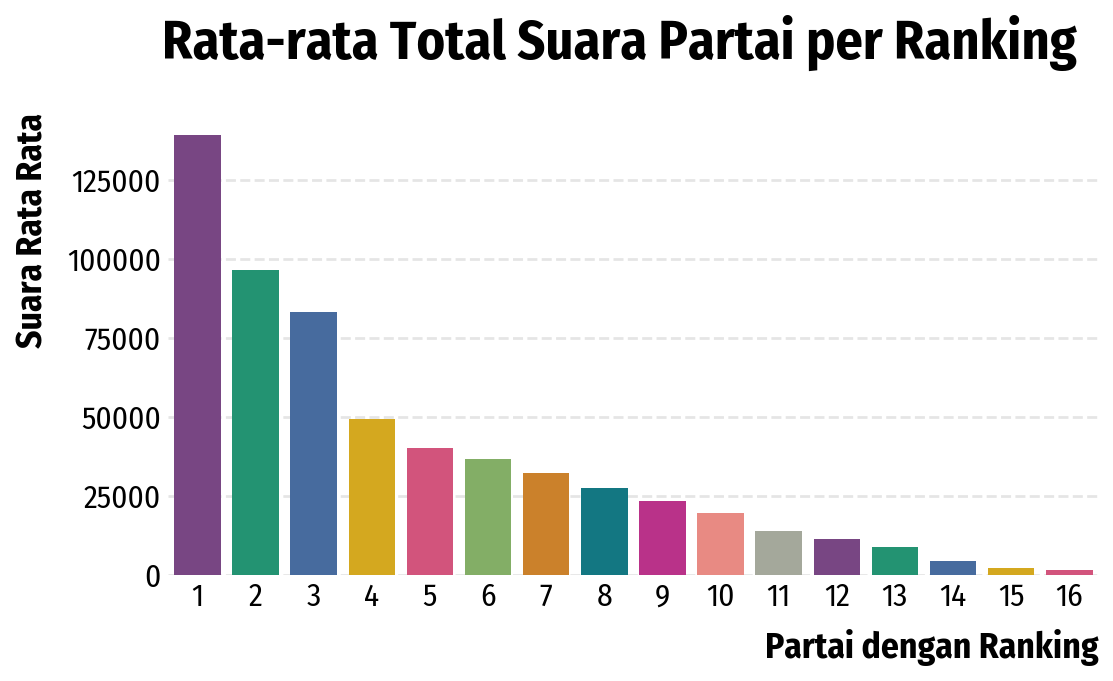

In [182]:
ax = plt.figure(figsize=(8, 4), dpi=150)
sns.barplot(x=df_avg_ranking_vote.index, y=df_avg_ranking_vote["Suara Rata Rata"], palette=cmaps.bold._colors)
opinionated.set_title_and_suptitle(
    "Rata-rata Total Suara Partai per Ranking",
    "",
)
plt.show()

Bisa kita lihat bahwa rata-rata perolehan suara partai di tiap dapil sangat tidak seimbang. Secara rata-rata, partai dengan ranking 1, 2 dan 3 sangat mendominasi.

Dengan distribusi suara seperti ini, maka secara rata-rata, jumlah kursi yang akan didapatkan masing-masing partai dengan metode Sainte Lague adalah sebagai berikut.

In [140]:
from collections import Counter
avg_vote_per_rank = df_avg_ranking_vote.to_dict().get("Suara Rata Rata")
selected_partai = module.get_selected_partai(avg_vote_per_rank, 12, with_rank=False)
selected_partai = {k:v for k, v in Counter(selected_partai).items()}
for k, v in selected_partai.items():
    print(f"Partai dengan ranking {k} : {v} kursi")

Partai dengan ranking 1 : 3 kursi
Partai dengan ranking 2 : 2 kursi
Partai dengan ranking 3 : 2 kursi
Partai dengan ranking 4 : 1 kursi
Partai dengan ranking 5 : 1 kursi
Partai dengan ranking 6 : 1 kursi
Partai dengan ranking 7 : 1 kursi
Partai dengan ranking 8 : 1 kursi


Dengan hasil seperti ini, bila ada calon dari partai dengan ranking 9 yang mendapat suara terbanyak di dapil tersebut, maka suara yang calon ini dapat percuma. <span style="color: purple; font-weight: bold;">Efek dari pemakaian metode Sainte Lague adalah, jika suatu calon ingin terpilih, maka partai calon tsb. harus mendapatkan jatah kursi terlebih dulu.</span>

Kemudian, bagi calon yang berasal dari partai terpilih, jumlah suara yang calon terima relatif terhadap semua calon di dapil tersebut tidak relevan. Yang terpenting adalah jumlah suara yang seorang yang calon terima relatif terhadap calon di partai yang sama. Misal kita gunakan partai dengan ranking 4 dan 5 sebagai contoh:

Partai dengan ranking 4:
- Jatah kursi = 1
- Calon ranking 1 : 10.000 suara -> terpilih
- Calon ranking 2 : 8.000 suara

Partai dengan ranking 5:
- Jatah kursi = 1
- Calon ranking 1 : 20.000 suara -> terpilih
- Calon ranking 2 : 15.000 suara

Partai dengan ranking 4 dan 5 sama sama mendapat 1 kursi. Bisa kita lihat, 
- calon dengan ranking 1 dari partai 4 mendapat 10.000 suara tetapi terpilih
- calon dengan ranking 2 dari partai 5 mendapat 15.000 suara tetapi tidak terpilih, padahal suaranya lebih banyak

Inilah yang dimaksud dari kalimat di awal, bahwa <span style="color: purple; font-weight: bold;">bagi calon yang berasal dari partai terpilih, jumlah suara yang calon terima relatif terhadap semua calon di dapil tersebut tidak relevan. Yang terpenting adalah jumlah suara yang seorang calon terima relatif terhadap calon di partai yang sama.</span>
 Bila partai calon mendapat 3 jatah kursi, maka 3 calon teratas di partai tsb. yang terpilih. Bila partai calon mendapat 1 jatah kursi, maka 1 calon teratas di partai tsb. yang terpilih. Dan seterusnya.

Note: angka imaginer sebagai contoh

Kemudian, dari hasil ini, kita akan melihat berapa angka rata-rata yang diperlukan oleh calon dari masing-masing partai untuk bisa terpilih.

In [141]:
avg_vote_per_rank = df_avg_ranking_vote.to_dict().get("Suara Rata Rata")
selected_partai = module.get_selected_partai(avg_vote_per_rank, 12, with_rank=False)
selected_partai = {k:v for k, v in Counter(selected_partai).items()}
for k, v in selected_partai.items():
    print(f"Partai dengan ranking {k} : {v} kursi")

Partai dengan ranking 1 : 3 kursi
Partai dengan ranking 2 : 2 kursi
Partai dengan ranking 3 : 2 kursi
Partai dengan ranking 4 : 1 kursi
Partai dengan ranking 5 : 1 kursi
Partai dengan ranking 6 : 1 kursi
Partai dengan ranking 7 : 1 kursi
Partai dengan ranking 8 : 1 kursi


In [142]:
partai_ranking = (df
    .groupby(["dapil_no", "partai"])
    .agg(partai_vote=("partai_vote", "mean"), vote=("vote", "sum"))
    .reset_index()
    .assign(total_vote=lambda df_: df_["partai_vote"] + df_["vote"])
    .drop(columns=["partai_vote", "vote"])
    .sort_values(["dapil_no", "total_vote"], ascending=[True, False], ignore_index=True)
    .assign(partai_dengan_ranking=lambda df_: df_.groupby("dapil_no").cumcount(ascending=True) + 1)
    .drop(columns="total_vote")
)

(df
    .merge(
        partai_ranking, 
        left_on=["dapil_no", "partai"], 
        right_on=["dapil_no", "partai"], 
        how="left"
    )
    .assign(ranking_calon=lambda df_: (df_
                                       .sort_values("vote", ascending=False)
                                       .groupby(["dapil_no", "partai"])
                                       .cumcount(ascending=True) + 1)
    )
    .groupby(["partai_dengan_ranking", "ranking_calon"])
    .agg(suara=("vote", "mean"))
    .reset_index()
    .loc[lambda df_: 
        (df_["partai_dengan_ranking"] == 1) & (df_["ranking_calon"] <= 3)
        |
        (df_["partai_dengan_ranking"].isin([2, 3])) & (df_["ranking_calon"] <= 2)
        |
        (df_["partai_dengan_ranking"].isin(list(range(3, 9)))) & (df_["ranking_calon"] <= 1)
    ]
    .rename(columns=lambda c: c.replace("_", " ").title())
    .set_index("Partai Dengan Ranking")
    .pivot(columns=["Ranking Calon"])
    .fillna("")
    .droplevel(0, axis=1)
)

Ranking Calon,1,2,3
Partai Dengan Ranking,,,
1,27267.1,14166.9,11481.9
2,20422.5,10719.6,
3,17637.1,9498.1,
4,11790.7,,
5,11598.5,,
6,10073.1,,
7,9531.8,,
8,8267.6,,


Cara membaca tabel di atas adalah sebagai berikut: 
- Secara rata-rata, partai dengan ranking 1 memiliki 3 calon terpilih yang jumlah suara masing-masing = 27.267, 14.166, 11.481
- Secara rata-rata, partai dengan ranking 2 memiliki 2 calon terpilih yang jumlah suara masing-masing = 20.422, 10.719
- Secara rata-rata, partai dengan ranking 3 memiliki 2 calon terpilih yang jumlah suara masing-masing = 17.637, 9.498
- Dan seterusnya

Bisa kita lihat, jumlah suara yang diperlukan calon agar bisa terpilih bervariasi, tergantung dari ranking partainya. Calon dari partai dengan ranking tinggi memerlukan banyak suara untuk terpilih, sedangkan calon dari partai dengan ranking rendah memerlukan lebih sedikit suara untuk terpilih.

Note:
Perlu diingat bahwa angka di atas adalah angka rata-rata. Ada calon yang terpilih dengan lebih dari 30.000 suara atau lebih sedikit dari 7.000 suara. Namun, lebih aman bila kita mengambil angka rata-rata.

### 7.1 Kesimpulan

Tabel di atas menjawab 2 pertanyaan kita: 

1. Calon Manakah yang Diuntungkan dengan Metode Sainte Lague? 

    <span style="color: purple; font-weight: bold;">Calon yang diuntungkan adalah calon dari partai yang mendapat jatah kursi tetapi partainya memiliki ranking rendah, karena jumlah suara yang mereka perlukan untuk dapat terpilih lebih sedikit jika dibandingkan calon dari partai dengan ranking tinggi.</span>

2. Berapa Suara yang Dibutuhkan untuk Terpilih?
    
    Suara rata-rata yang diperlukan untuk bisa terpilih bisa dilihat di tabel di atas. 

---

## 8. Dapil Mana yang Paling Tidak Ketat?

Kata "tidak ketat" disini memiliki banyak arti. Kita akan melihat satu persatu.

### 8.1 Dapil Dimana Tidak Ada Partai yang Terlalu Mendominasi

Untuk menilai apakah suatu dapil didominasi oleh sedikit partai, kita akan menggunakan metrics bernama "Fisher-Pearson coefficient of skewness". Metrics ini mengukur sejauh mana data cenderung condong ke salah satu sisi dari distribusi. Bila nilainya besar, maka distribusi data condong ke salah satu sisi (suara condong ke partai tertentu).

Referensi: [Fisher-Pearson coefficient of skewness](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/pearsons-coefficient-of-skewness/)

In [230]:
from scipy.stats import skew


suara_partai_per_dapil = (df
    .groupby(["dapil_no", "dapil_nama", "partai"])
    .agg(
        vote_untuk_partai=("partai_vote", "mean"),
        vote_untuk_calon=("vote", "sum"),
    )
    .reset_index()
    .assign(
        dapil=lambda df_: ("Dapil " + df_["dapil_no"].astype(str) + " - " + df_["dapil_nama"]), 
        total_suara=lambda df_: (df_["vote_untuk_calon"] + df_["vote_untuk_partai"]), 
        skewness=lambda df_: df_.groupby("dapil")["total_suara"].transform(skew)
    )
    .drop(columns=["vote_untuk_partai", "vote_untuk_calon", "dapil_no", "dapil_nama"])
    .sort_values(["skewness", "total_suara"], ascending=[True, False])
)

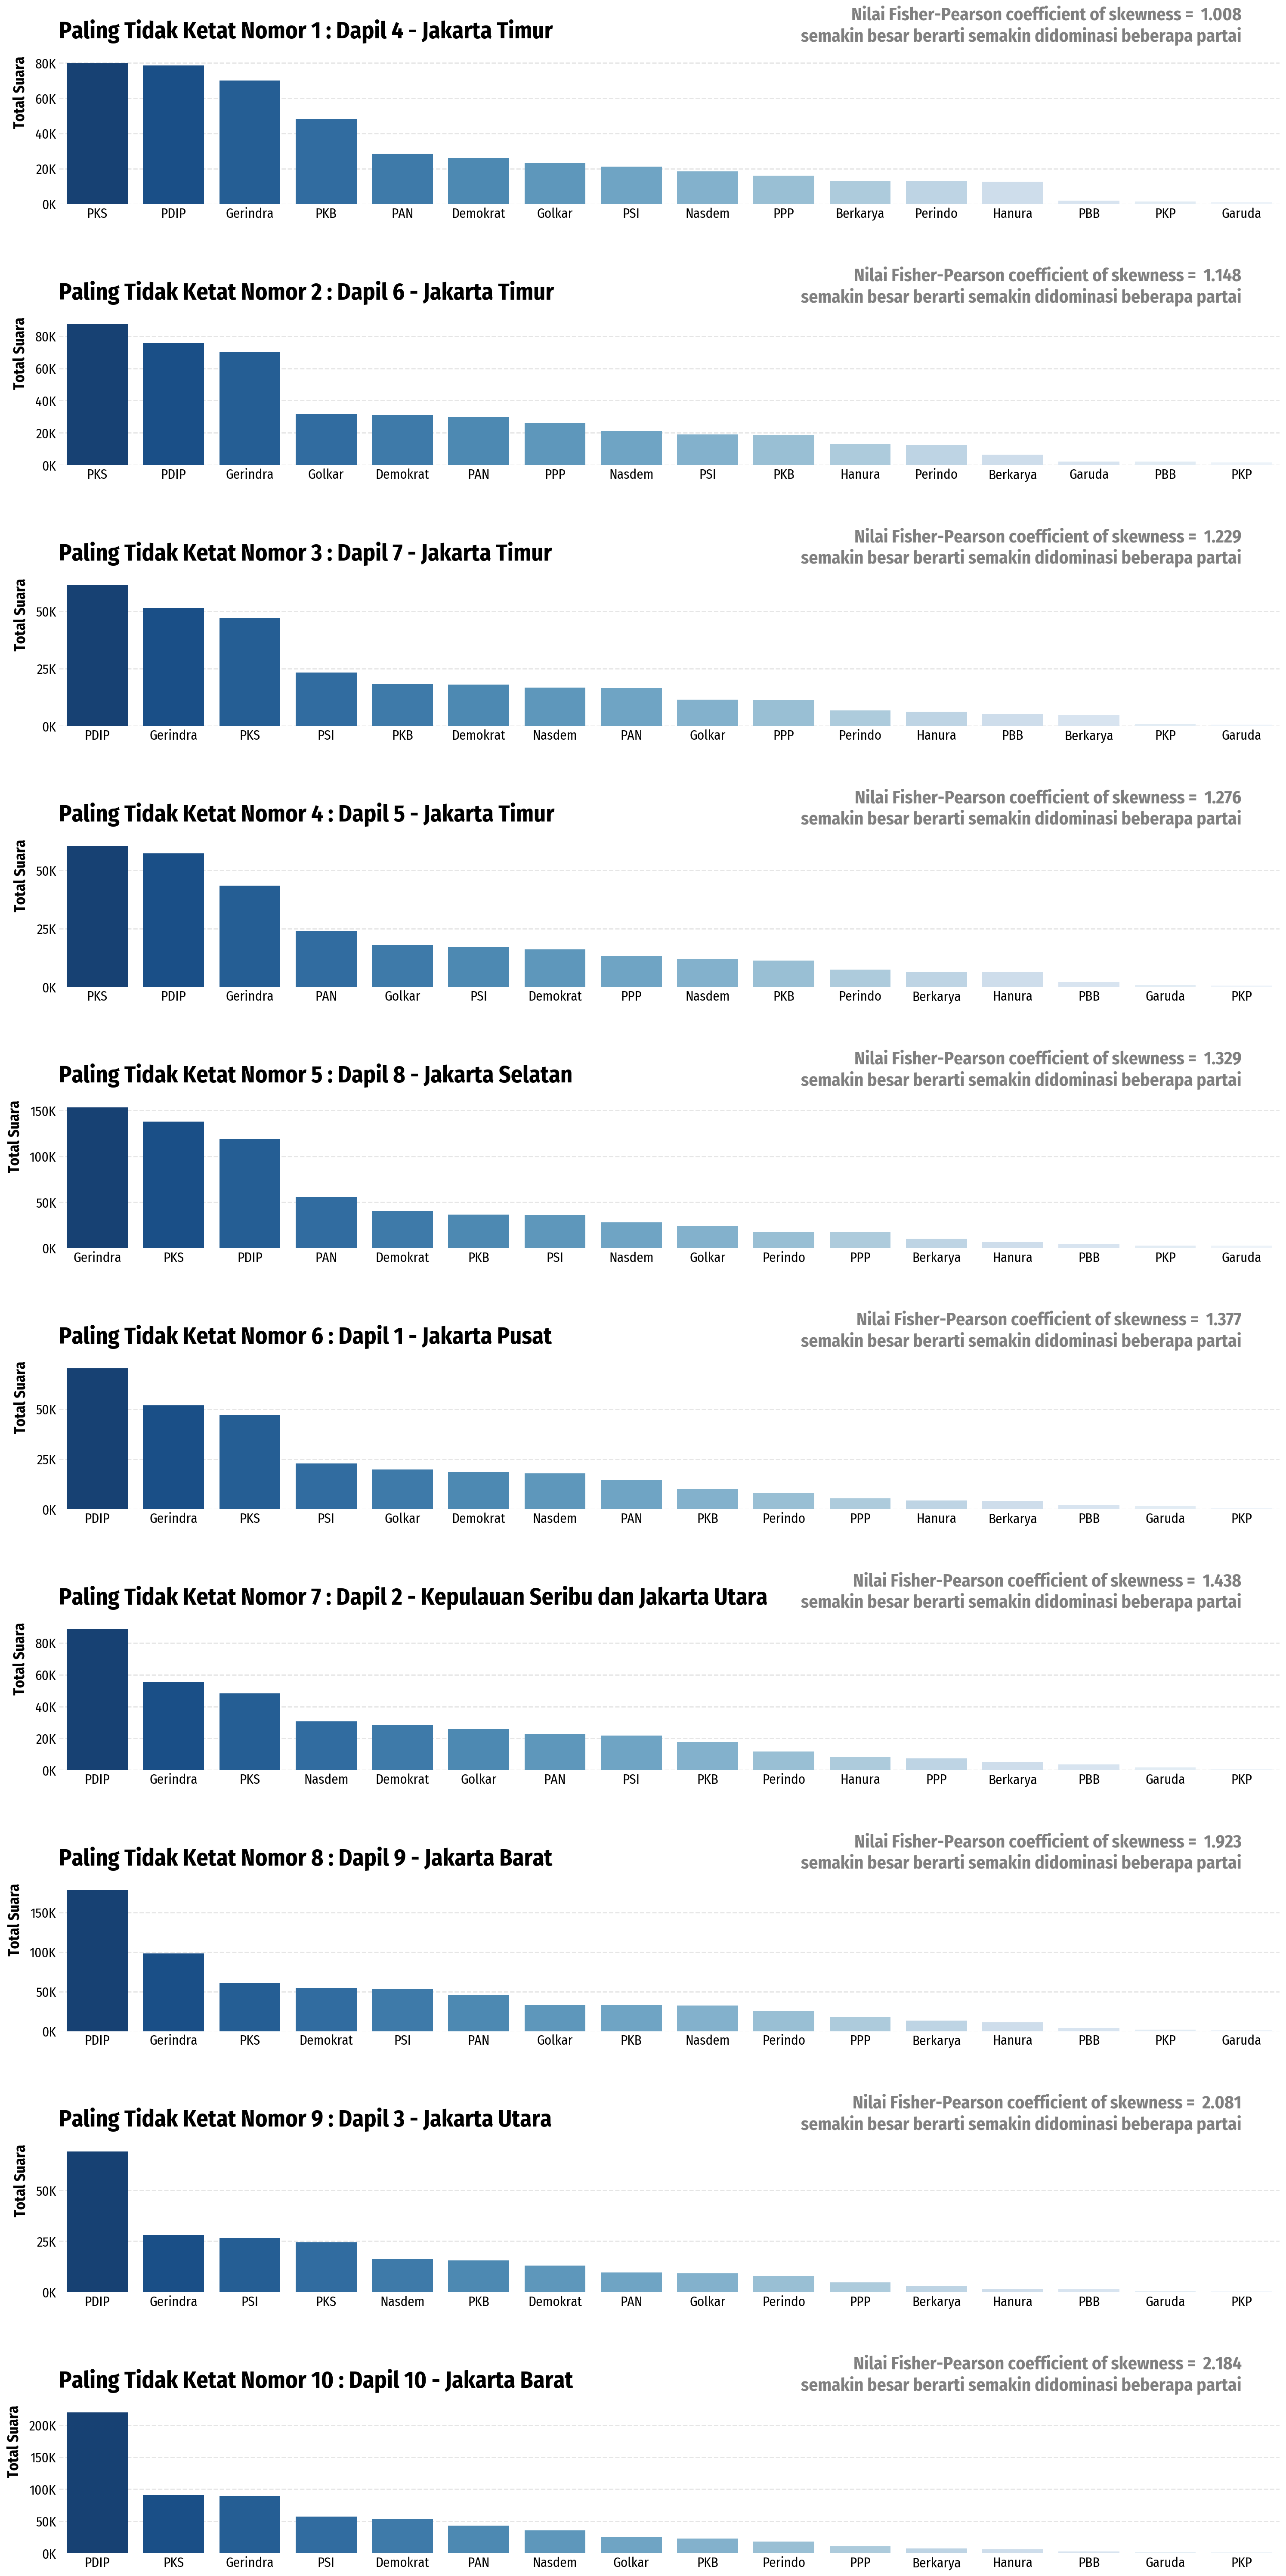

In [229]:
dapils = suara_partai_per_dapil["dapil"].unique()
fig = plt.figure(figsize=(20, 40), dpi=150)

for i, dapil in enumerate(dapils, 1):
    # get data
    data = suara_partai_per_dapil.loc[suara_partai_per_dapil["dapil"] == dapil]
    # create axis and plot
    ax = plt.subplot(10, 1, i)
    sns.barplot(data, x="partai", y="total_suara", palette="Blues_r")
    # set axis label, title and subtitle
    ax.set_ylabel("Total Suara")
    ax.set_xlabel("")
    title = f"Paling Tidak Ketat Nomor {i} : {dapil}"
    subtitle = (
        f'Nilai Fisher-Pearson coefficient of skewness = {data["skewness"].unique()[0]: .3f}\nsemakin besar berarti semakin didominasi beberapa partai'
    )
    ax.set_title(title)
    ax.text(
        x=15,
        y=ax.get_ylim()[-1] * 1.1,
        s=subtitle,
        fontsize=20,
        ha="right",
        va="baseline",
        fontweight="bold",
        color="grey",
    )
    # set xticklabels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ylabels = ["{:,.0f}".format(x) + "K" for x in ax.get_yticks() / 1000]
        ax.set_yticklabels(ylabels)

plt.tight_layout(w_pad=5, h_pad=5, pad=1)
plt.show()

Bisa kita lihat dari chart di atas, dapil 4 Jakarta Timur merupakan dapil yang paling tidak ketat. Walaupun suara didominasi PKS, tapi partai dengan ranking 2 dan 3 tidak terlalu jauh tertinggal. Selain itu, Partai-partai dengan ranking 4 sampai 10 juga mendapat suara yang signifikan.

Hal ini berbanding terbalik dengan dapil 10 yang merupakan dapil terketat. Bisa kita lihat, PDIP mendapat suara yang luar biasa banyak. Partai dengan ranking 2 mendapat suara kurang dari 50% dari suara PDIP. 

Sebagai insight tambahan, 4 dapil paling tidak ketat semuanya ada di Jakarta Timur.

---

## Kesimpulan Akhir

Berdasarkan analisis di atas, skenario terbaik untuk terpilih dalam pemilihan DPRP DKI Jakarta adalah: 
1. Bergabung menjadi calon dari partai besar. Kemungkinan terpilih calon dari partai besar jauh lebih tinggi daripada kemungkinan terpilih calon dari partai kecil.
2. Hindari gambling bergabung dengan partai kecil. Sangat kecil kemungkinan calon dari partai kecil untuk terpilih, bahkan mendekati 0%. Satu-satunya calon terpilih dari partai kecil (mengesampingkan Golkar) adalah Matnoor Tindoan, S.H., seorang 2x incumbent yang sudah memiliki base yang kuat di dapilnya. 
3. Menjadi calon dengan nomor urut kecil. Berbagai penelitian akademis menunjukkan adanya *ballot-order effect*, dimana calon dengan nomor urut kecil lebih mungkin terpilih.
4. Sesuaikan partai dengan dapil. Di tiap dapil, terdapat partai-partai yang lebih kuat dari partai lainnya. Chart kekuatan partai di tiap dapil dapat dilihat di point 3. 